# Summary of Modeling for SPDR ETFs

In this notebook, I will summarize my findings from iterating through a host of models for the 11 sector ETFs for time frames of 1, 3, 6, and 12 months. The best scoring models performed incredibly well, and did not exhibit any characteristics of overfitting. There were still instances wherein the models predicted "buys" incorrectly, but the models generally did a good job of mitigating the magnitude of losses. I will begin by summarizing each sector's performance separately. 

### Disclaimer: This notebook should not be considered any kind of financial advice. It exists only for the purposes of practicing modeling and making predictions 

![One Tree of an ExtraTreesClassifier Ensemble](./Files/extra_tree.jpg)

# Imports and Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

import datetime as dt

# New import of my custom class
from classification_classes import Model
from spider_classes import Materials, Energy, Financials, Industrials, Technology, Staples, Utilities, Health, \
Consumer, Real_Estate, Communication_Services
from other_functions import compare_curves

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 35)
sns.set_style("dark")

import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

import pickle

In [76]:
# Feature Importances for the best models of each sector/timeframe
feature_importances = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Feature_Importances.csv')
feature_importances.rename(columns={"Unnamed: 0": "Model Target"}, inplace=True)
feature_importances.set_index("Model Target", inplace=True)

# Complete table of results
models_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/ALL_MODEL_DATA.csv', index_col=0)
models_df.loc[28, 'name'] = "Gridsearched ETC Materials 12-Month"

# Original Data 
df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/SPDR_DATA_W_ADDED.csv')
# df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/FULL_DATA_W_PERC_CHANGES.csv')
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

In [77]:
df.head()

,Ticker,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,...,dollar_volume(M),Quarter,Month,cycle_year,day_of_week,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-01-29,XLB,12.173973,21.109375,21.109375,20.953125,20.953125,400.0,9411.682,4.37,0.0095,0.001,-0.0062,0.0044,-0.0057,-0.113866,45.359196,11.895113,...,0.0049,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,0.003700,0.304891,0.224777,0.120443,1.0,1.0,1.0,1.0
1999-01-29,XLE,11.670672,21.812500,21.812500,21.437500,21.687500,18600.0,9411.682,4.37,0.0095,0.001,-0.0062,0.0044,-0.0057,-0.148177,31.112318,11.538886,...,0.2171,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,-0.018624,0.321353,0.294086,0.272486,0.0,1.0,1.0,1.0
1999-01-29,XLF,11.877566,19.369415,19.394800,18.810926,19.077478,72998.0,9411.682,4.37,0.0095,0.001,-0.0062,0.0044,-0.0057,-0.086272,53.698896,11.237432,...,0.8670,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,0.019659,0.138006,0.056829,-0.020673,1.0,1.0,1.0,0.0
1999-01-29,XLI,15.624509,24.296875,24.406250,23.953125,24.234375,109200.0,9411.682,4.37,0.0095,0.001,-0.0062,0.0044,-0.0057,-0.074248,54.474621,15.080736,...,1.7062,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,0.008360,0.199315,0.202136,0.131147,1.0,1.0,1.0,1.0
1999-01-29,XLK,28.604773,37.812500,37.843750,36.937500,37.375000,933600.0,9411.682,4.37,0.0095,0.001,-0.0062,0.0044,-0.0057,-0.027333,69.725520,24.579485,...,26.7054,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,-0.103306,-0.018595,0.069421,0.337216,0.0,0.0,1.0,1.0


In [78]:
# Load Pickled Classes -> if you want access, please reach out to me directly

with open('/Users/samalainabayeva/Desktop/Capstone Project/SPDR_classes.pkl', 'rb') as file:
    model_collection = pickle.load(file)

In [79]:
# Providing access to Class Objects

Materials = model_collection[0]
Energy = model_collection[1]
Financials = model_collection[2]
Industrials = model_collection[3]
Technology = model_collection[4]
Staples = model_collection[5]
Utilities = model_collection[6]
Health = model_collection[7]
Consumer_Disc = model_collection[8]
Real_Estate = model_collection[9]
Comms = model_collection[10]

In [80]:
# Metric dfs of the models from the previous notebook

Materials_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Materials.csv', index_col=0)
Energy_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Energy.csv', index_col=0)
Financials_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Financials.csv', index_col=0)
Industrials_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Industrials.csv', index_col=0)
Technology_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Technology.csv', index_col=0)
Staples_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Staples.csv', index_col=0)
Utilities_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Utilities.csv', index_col=0)
Health_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Health_Care.csv', index_col=0)
Consumer_Disc_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Consumer_Disc.csv', index_col=0)
Real_Estate_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Real_Estate.csv', index_col=0)
Comms_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Communication_Services.csv', index_col=0)

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_test_accuracy(df, sector_name:str, num_include=-1):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(10,7))
    palette = sns.color_palette("flare", n_colors=10)
    data = df[['name', 'test_accuracy']].sort_values(by="test_accuracy", ascending=False)[0:num_include]
    sns.barplot(data=data, y='name', x="test_accuracy", palette=palette)
    ax.set_xlabel("Test Accuracy")
    ax.set_ylabel("Model Name")
    ax.set_title(f"Performance of Models - {sector_name}")
    ax.set_xticks(np.arange(0,1,.1))
    ax.set_xticklabels(np.arange(0,100,10))
    plt.grid(False);
    
    
    
feature_importances = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Feature_Importances.csv')
feature_importances.rename(columns={"Unnamed: 0": "Model Target"}, inplace=True)
feature_importances.set_index("Model Target", inplace=True)
    
    
    
def print_feature_importances(start, stop, interval=1, feats=5, data=feature_importances):
    for i in range(start, stop, interval):
        print("*" *40)
        print(f"Top {feats} Feature Importance(s):")
        print(feature_importances.iloc[i].sort_values(ascending=False)[:feats])
        
        

def describe_predictions(model, ticker, df=df, cat=1, box=False):
    targets = df[df["Ticker"] == ticker][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                                         'Twelve_Month_Change']]

    combined_df = model.X_test.join(targets)
    predictions = list(model.y_pred)
    combined_df["Y_PREDS"] = predictions
    
    # Add this stuff
    if box:
        assess_positive_preds = combined_df[combined_df["Y_PREDS"] == 1]

        fig, ax = plt.subplots(figsize=(6,5.5))
        sns.set_style("darkgrid")
        palette = sns.color_palette("rocket_r", n_colors=6)
        sns.boxplot(assess_positive_preds[["One_Month_Change", 'Three_Month_Change','Six_Month_Change',\
                                           'Twelve_Month_Change']], ax=ax, palette=palette)
        ax.set_title(f"{model.name} Box Plot for Each Timeframe")
        plt.xticks(rotation=30)
        ax.set_ylabel("Percentage Change in Decimals");
    else:
        print("Set 'box' to 'True' if you want to see box plots")

    return combined_df[combined_df["Y_PREDS"] == cat][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change',\
                                                     'Twelve_Month_Change']].describe()


def show_time_horizon(df, time_horizon):
    time_dict = {"One":"1-Month", "Three":"3-Month", "Six":'6-Month', "Twelve":'12-Month'}
    return df[df['name'].str.contains(str(time_dict[time_horizon]))].sort_values(by="test_accuracy", ascending=False)

<hr style="border: 4px solid blue">

# Top Ten Models Overall

In [82]:
models_df.sort_values(by="test_accuracy", ascending=False)[:10]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
121,"GridSearched Best-Model, 12-Month Technology",0.980231,0.981350,0.992506,0.986880,0.084918,0.987205,0.990222,0.992870,0.991544,0.052344,0.998891
118,Technology Random Forest 12-Month,0.978434,0.979596,0.991907,0.985694,0.077740,0.986532,0.990214,0.991979,0.991095,0.051671,0.998922
233,Real_Estate Extra Trees 6-Month,0.969419,0.977478,0.974914,0.976106,0.095903,0.986239,0.996466,0.982578,0.989474,0.143288,0.995300
266,"GridSearched Best-Model, 12-Month Communicatio...",0.985016,0.987254,0.990826,0.989015,0.092408,0.985075,0.982659,0.994152,0.988372,0.054820,0.997377
264,Communication_Services Extra Trees 12-Month,0.982516,0.985485,0.988991,0.987197,0.092167,0.985075,0.982659,0.994152,0.988372,0.046553,0.998704
119,Technology Extra Trees 12-Month,0.980008,0.984525,0.988911,0.986693,0.072815,0.984512,0.988444,0.991087,0.989764,0.042637,0.999099
47,Energy Extra Trees 12-Month,0.977987,0.980082,0.986714,0.983361,0.073745,0.983838,0.988978,0.987000,0.987988,0.056978,0.998055
49,"GridSearched Best-Model, 12-Month Energy",0.977987,0.980082,0.986714,0.983361,0.073745,0.983838,0.988978,0.987000,0.987988,0.056978,0.998055
120,Technology XGBoost 12-Month,0.977761,0.982164,0.988311,0.985211,0.086091,0.983838,0.986702,0.991979,0.989333,0.054686,0.995889
232,Real_Estate Random Forest 6-Month,0.964061,0.971785,0.972512,0.971971,0.108880,0.981651,0.992933,0.979094,0.985965,0.089284,0.994306


<hr style="border: 4px solid black">

# Best Models for Different Time Horizons
### Top 5 Models for 1-Month Predictions

In [83]:
show_time_horizon(models_df, "One").sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
245,Communication_Services Extra Trees 1-Month,0.905093,0.923258,0.920461,0.921070,0.224529,0.921642,0.906040,0.950704,0.927835,0.235663,0.970909
199,"GridSearched Best-Model, 1-Month Consumer",0.901841,0.914124,0.930799,0.922370,0.287610,0.919865,0.919235,0.952643,0.935641,0.225776,0.972471
197,Consumer Extra Trees 1-Month,0.901167,0.911974,0.932233,0.921984,0.275765,0.918519,0.919957,0.949339,0.934417,0.229149,0.971568
101,Technology Extra Trees 1-Month,0.903416,0.914665,0.928156,0.921318,0.268386,0.918519,0.923830,0.943333,0.933480,0.223019,0.972975
247,"GridSearched Best-Model, 1-Month Communication...",0.917585,0.932046,0.931009,0.931198,0.225517,0.917910,0.905405,0.943662,0.924138,0.239445,0.969931


### Top 5 Models for 3-Month Predictions

In [84]:
show_time_horizon(models_df, "Three").sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
205,"GridSearched Best-Model, 3-Month Consumer",0.941150,0.956009,0.954043,0.955022,0.173759,0.959596,0.963265,0.975207,0.969199,0.120060,0.992797
203,Consumer Extra Trees 3-Month,0.941150,0.956009,0.954043,0.955022,0.173759,0.959596,0.963265,0.975207,0.969199,0.120060,0.992797
109,"GridSearched Best-Model, 3-Month Technology",0.952829,0.955530,0.974737,0.964980,0.162295,0.958249,0.959486,0.978831,0.969062,0.155356,0.987532
106,Technology Random Forest 3-Month,0.952829,0.955530,0.974737,0.964980,0.162295,0.958249,0.959486,0.978831,0.969062,0.155356,0.987532
35,Energy Extra Trees 3-Month,0.939798,0.942024,0.962970,0.952365,0.213188,0.956229,0.950317,0.980371,0.965110,0.169099,0.987909


### Top 5 Models for 6-Month Predictions

In [85]:
show_time_horizon(models_df, "Six").sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
233,Real_Estate Extra Trees 6-Month,0.969419,0.977478,0.974914,0.976106,0.095903,0.986239,0.996466,0.982578,0.989474,0.143288,0.995300
232,Real_Estate Random Forest 6-Month,0.964061,0.971785,0.972512,0.971971,0.108880,0.981651,0.992933,0.979094,0.985965,0.089284,0.994306
235,"GridSearched Best-Model, 6-Month Real_Estate",0.971712,0.977536,0.978500,0.977951,0.118885,0.979358,0.989437,0.979094,0.984238,0.070450,0.995884
260,"GridSearched Best-Model, 6-Month Communication...",0.990000,0.993814,0.989754,0.991774,0.123804,0.977612,0.987500,0.975309,0.981366,0.086089,0.995341
259,Communication_Services XGBoost 6-Month,0.977523,0.977734,0.985651,0.981663,0.086794,0.977612,0.993671,0.969136,0.981250,0.085382,0.996098


### Top 5 Models for 12-Month Predictions

In [86]:
show_time_horizon(models_df, "Twelve").sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
121,"GridSearched Best-Model, 12-Month Technology",0.980231,0.981350,0.992506,0.986880,0.084918,0.987205,0.990222,0.992870,0.991544,0.052344,0.998891
118,Technology Random Forest 12-Month,0.978434,0.979596,0.991907,0.985694,0.077740,0.986532,0.990214,0.991979,0.991095,0.051671,0.998922
266,"GridSearched Best-Model, 12-Month Communicatio...",0.985016,0.987254,0.990826,0.989015,0.092408,0.985075,0.982659,0.994152,0.988372,0.054820,0.997377
264,Communication_Services Extra Trees 12-Month,0.982516,0.985485,0.988991,0.987197,0.092167,0.985075,0.982659,0.994152,0.988372,0.046553,0.998704
119,Technology Extra Trees 12-Month,0.980008,0.984525,0.988911,0.986693,0.072815,0.984512,0.988444,0.991087,0.989764,0.042637,0.999099


<hr style="border: 4px solid black">

# Sector Analysis

### Notebook Analysis Layout:
- Materials
- Energy
- Financials
- Industrials 
- Technology
- Staples 
- Utilities 
- Health Care
- Consumer Discretionary 
- Real Estate 
- Communication Services
- ##### Final Summary

# Materials XLB

The data for the Materials sector shows that on a shorter time horizon, momentum has the greatest relative importance, as evidenced by the technical indicators having the greatest influence on purity for the 1-month model. The longer the time horizon, the more macro-economic factors like interest rates and GDP were creating meaningful splits in our tree-based models. The worst false positive resulted in a `5.7% loss.` The `maximum gain for a "buy" prediction was 102.3%.` 

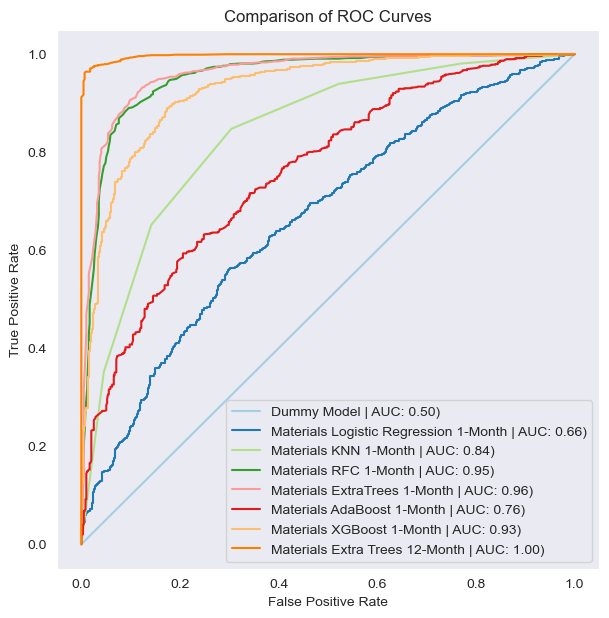

In [87]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Materials[0], Materials[1],Materials[2],Materials[3],Materials[4],Materials[5], Materials[6], \
                Materials[23]])

# Model 23 for materials was the best performing model in the sector

### Best Models for the Sector

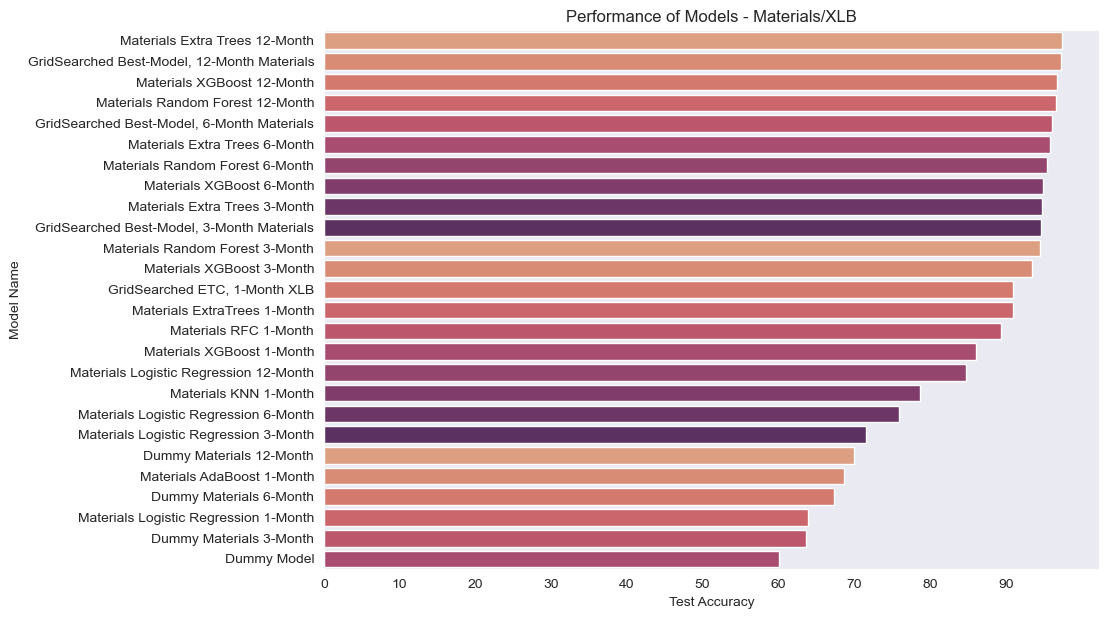

In [88]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Materials_df, "Materials/XLB", num_include=30)

In [89]:
# Top 5 Materials Models
Materials_df.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,Materials Extra Trees 12-Month,0.980909,0.985758,0.987302,0.986522,0.075691,0.974411,0.985451,0.977863,0.981643,0.066690,0.997332
25,"GridSearched Best-Model, 12-Month Materials",0.982481,0.987321,0.987937,0.987623,0.069957,0.973737,0.983559,0.978826,0.981187,0.066999,0.997403
24,Materials XGBoost 12-Month,0.974172,0.980989,0.982540,0.981752,0.078509,0.967677,0.977821,0.975938,0.976879,0.092482,0.995826
22,Materials Random Forest 12-Month,0.978886,0.985415,0.984762,0.985077,0.087830,0.966330,0.978703,0.973051,0.975869,0.089599,0.994893
19,"GridSearched Best-Model, 6-Month Materials",0.954401,0.960644,0.972943,0.966721,0.138573,0.960943,0.965449,0.977023,0.971202,0.116987,0.989978


### How did our model perform when predicting "BUY"?
Our best model was a 12-month model, based on the ExtraTreesClassifier. As you can see below, the `median return on predicted "buys" was 16.2%.` The worst outcome of 12-Month positive predictions was a `loss of 5.%`

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.015667,0.048181,0.097880,0.186685
std,0.061799,0.089089,0.117443,0.137149
min,-0.328935,-0.331800,-0.280945,-0.050330
25%,-0.013675,-0.002084,0.021283,0.096142
50%,0.019244,0.052185,0.092851,0.162374
75%,0.048951,0.098023,0.168149,0.245255
max,0.280052,0.496806,0.619264,1.023177


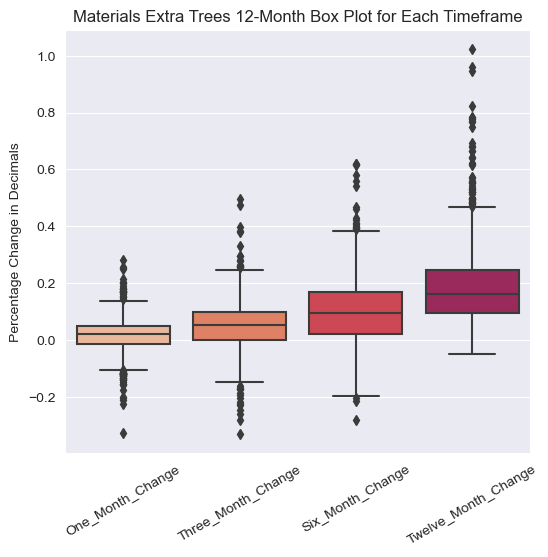

In [91]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Materials[23], "XLB", cat=1, box=True)

### Improvements
The confusion matrices below show how substantially our best model improved over the dummy model. The tree diagram at the beginning of the notebook displays how intricate decision trees can be, but impressively, none of the models were overfit in a meaningful way.

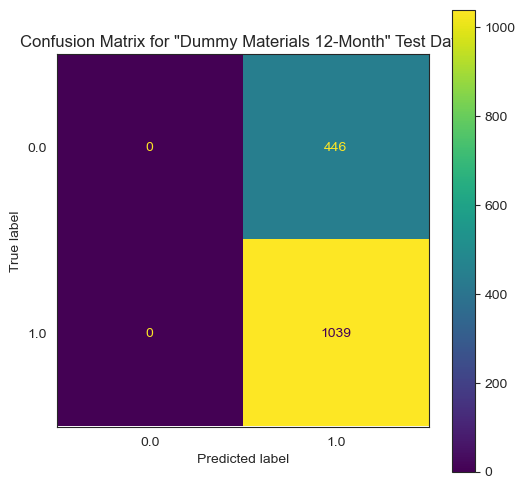

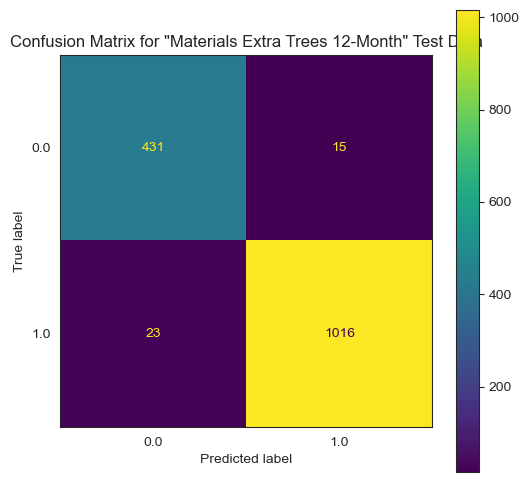

In [92]:
# Shows the best model's predictions and the dummy for that particular time horizon

Materials[20].confusion_matrix(), Materials[23].confusion_matrix();

### Feature Importances
Feature Importances for each time-horizon's best model. Keep in mind that after preprocessing and One Hot Encoding, that these models were built with `48 total feature columns.`  If all features were of equivalent value, they would each have an importance of roughly `0.021`. Also, these importances are not coefficients, but rather relative values of all features' importance, summing to 1.

In [93]:
# Feature Importances for each time-horizon's best model
print_feature_importances(0, 4, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
Interest_Rates           0.045234
20_day_SMA               0.045168
Adj Close                0.044890
MACD                     0.043671
one_up_bollinger_band    0.043399
Name: Materials 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest_Rates           0.052163
GDP_Filled               0.046539
lowest_bollinger_band    0.043753
Low                      0.041996
one_up_bollinger_band    0.041865
Name: Materials 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled               0.060676
Interest_Rates           0.059790
garman_klass_vol         0.043915
lowest_bollinger_band    0.042883
upper_bollinger_band     0.042523
Name: Materials 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.081880
Interest_Rates          0.059024
garman_klass_vol        

<hr style="border: 4px solid black">

# Energy XLE

Once again, the further out into the future our predictions, the more accurate our models became. 7 of my top 8 models were all for 6 or 12 month predictions. The short-term predictions were once again more influenced by technical indicators, and the longer term predictions were more affected by GDP and interest rates. Interestingly, `presidential term year 1` has shown to be a somewhat important feature. Another interesting note is that `Logistic Regression actually produced a model that was less accurate on test data than our dummy model`, even though its AUC and other metrics were slightly better. A major takeaway from this analysis was the persistent underperformance of Logistic Regression models at predicting future returns. The best model was again a 12-month model. `The max loss on positive predictions for that model and timeframe was around 2.9%`, whereas the `max gain was a staggering 120%.`

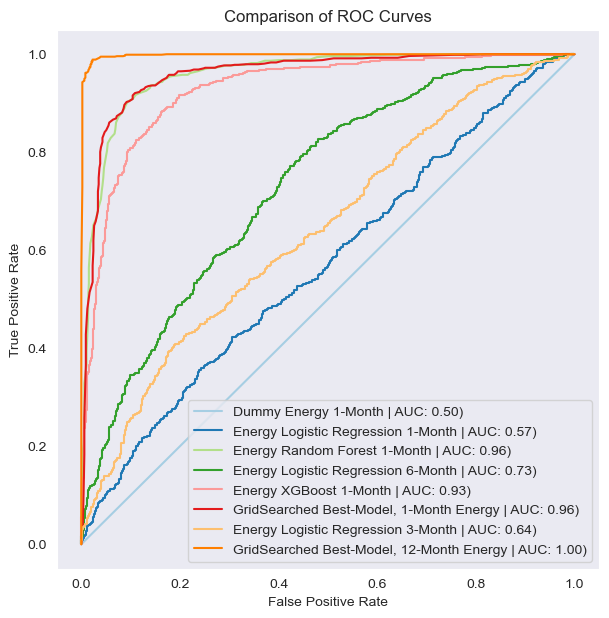

In [94]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Energy[0], Energy[1], Energy[2],Energy[13],Energy[4],Energy[5], Energy[7], Energy[23]])

# 23 was the best model of the sector

### Best Models for the Sector

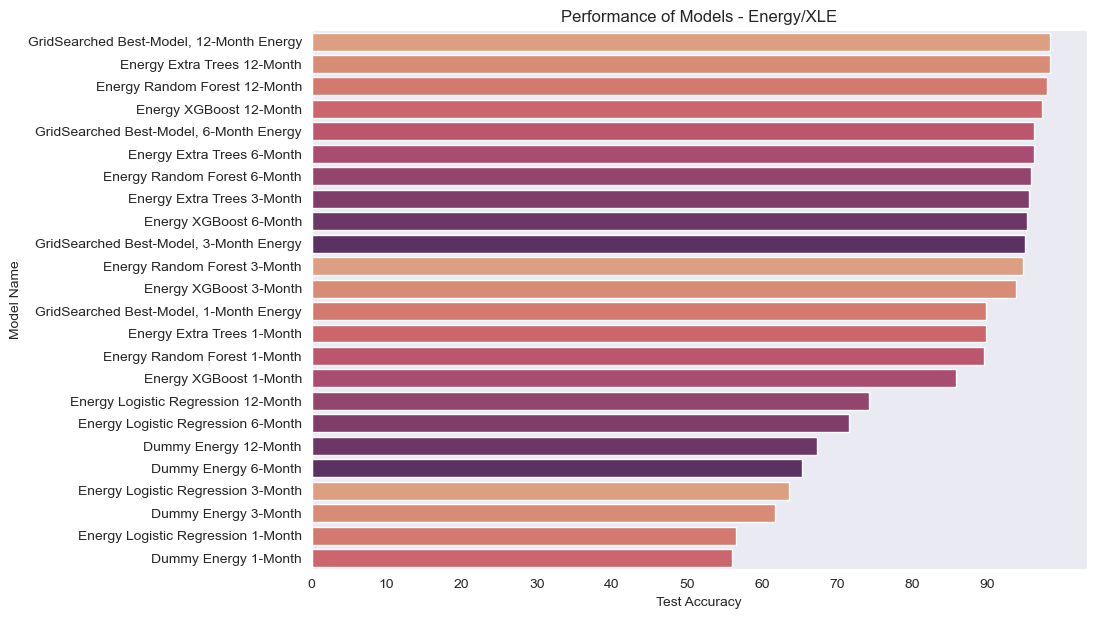

In [95]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Energy_df, "Energy/XLE", num_include=30)

In [96]:
# These were the models with the highest accuracy score for this ETF

Energy_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Energy",0.977987,0.980082,0.986714,0.983361,0.073745,0.983838,0.988978,0.987000,0.987988,0.056978,0.998055
21,Energy Extra Trees 12-Month,0.977987,0.980082,0.986714,0.983361,0.073745,0.983838,0.988978,0.987000,0.987988,0.056978,0.998055
20,Energy Random Forest 12-Month,0.972148,0.977318,0.980585,0.978916,0.079379,0.979798,0.982107,0.988000,0.985045,0.072762,0.997373
22,Energy XGBoost 12-Month,0.969227,0.972437,0.981264,0.976777,0.094764,0.973064,0.980000,0.980000,0.980000,0.084670,0.995786
17,"GridSearched Best-Model, 6-Month Energy",0.960469,0.968985,0.969657,0.969316,0.118624,0.962963,0.974093,0.969072,0.971576,0.099122,0.994797


### How did our model perform when predicting "BUY"?
The best model was a 12-month model, based on the ExtraTreesClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 22%. The worst outcome on a predicted "buy" was a loss of 2.86%.` 

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,998.000000,998.000000,998.000000,998.000000
mean,0.024299,0.068669,0.127278,0.260188
std,0.075947,0.110348,0.141586,0.187535
min,-0.406790,-0.241060,-0.234293,-0.028606
25%,-0.018779,-0.000340,0.038876,0.122613
50%,0.024204,0.060970,0.109652,0.219698
75%,0.065381,0.127820,0.190647,0.364352
max,0.465422,0.713057,0.816964,1.202586


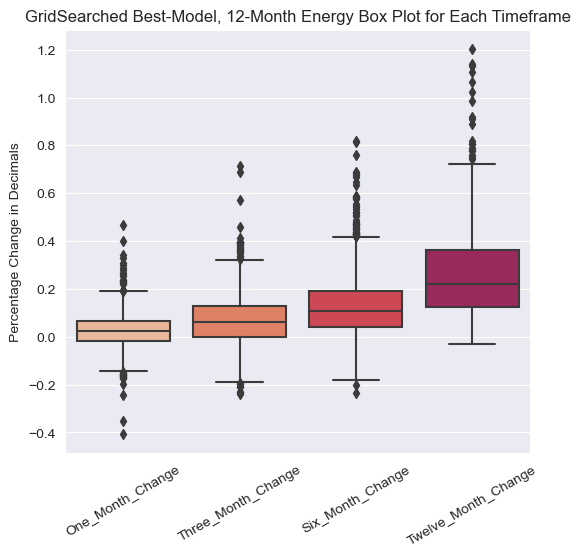

In [97]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Energy[23], "XLE", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

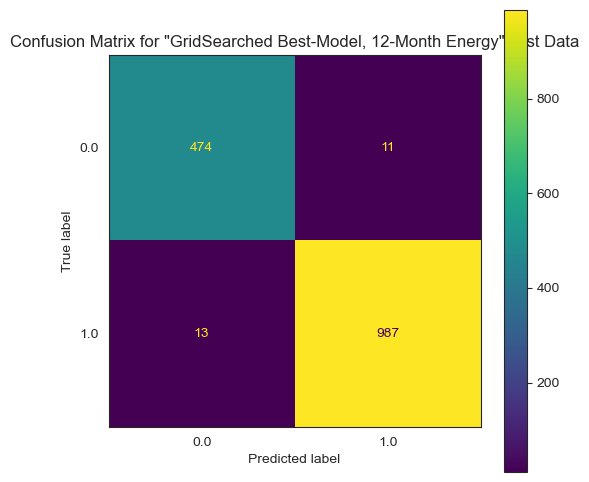

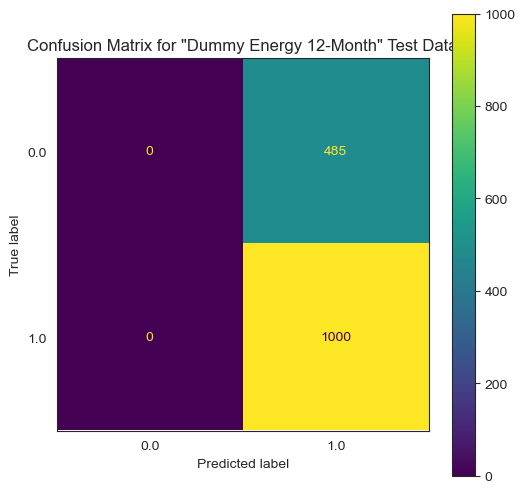

In [98]:
# Shows the best model's predictions and the dummy for that particular time horizon
Energy[23].confusion_matrix(), Energy[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [99]:
# Feature Importances for each time-horizon's best model
print_feature_importances(4, 8, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
Interest_Rates           0.044089
Close                    0.042283
upper_bollinger_band     0.041687
one_up_bollinger_band    0.041314
ATR                      0.041111
Name: Energy 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.050634
Interest_Rates          0.046981
Low                     0.043082
High                    0.041432
lower_bollinger_band    0.041374
Name: Energy 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled        0.058379
Interest_Rates    0.052434
cycle_year_1      0.043986
Low               0.043366
Adj Close         0.043184
Name: Energy 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled        0.075215
Interest_Rates    0.068485
cycle_year_1      0.064614
Low               0.053183
Adj Close         0.049606
Name

<hr style="border: 4px solid black">

# Financials XLF

Once again, the further out into the future our predictions, the more accurate our models became. My top 8 models were all for 6 or 12 month predictions. The short term predictions were once again more influenced by technical indicators, and the longer term predictions moreso by GDP and interest rates. Interestingly, `presidential term year 3` made an appearance as an important feature, as did `ATR, a technical indicator intended to measure volatility.` `Logistic Regression AGAIN produced a model that was barely more accurate on test data` than our dummy model. The best model made predictions for 12 months into the future. `Max loss on a positive prediction was 4%` and the `max gain was a massive 121.5%,` the largest one-year gain of the whole study. 

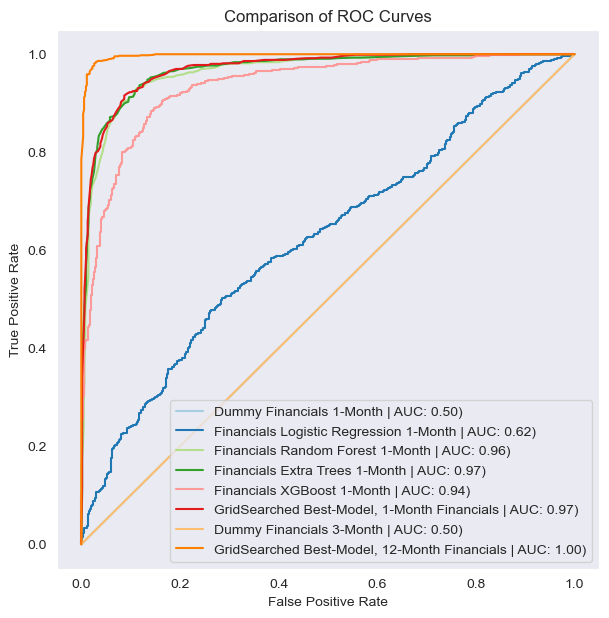

In [100]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Financials[0], Financials[1], Financials[2],Financials[3],Financials[4],Financials[5], \
                Financials[6], Financials[23]])

# Financials[23] is the best model overall for this sector

### Best Models for the Sector

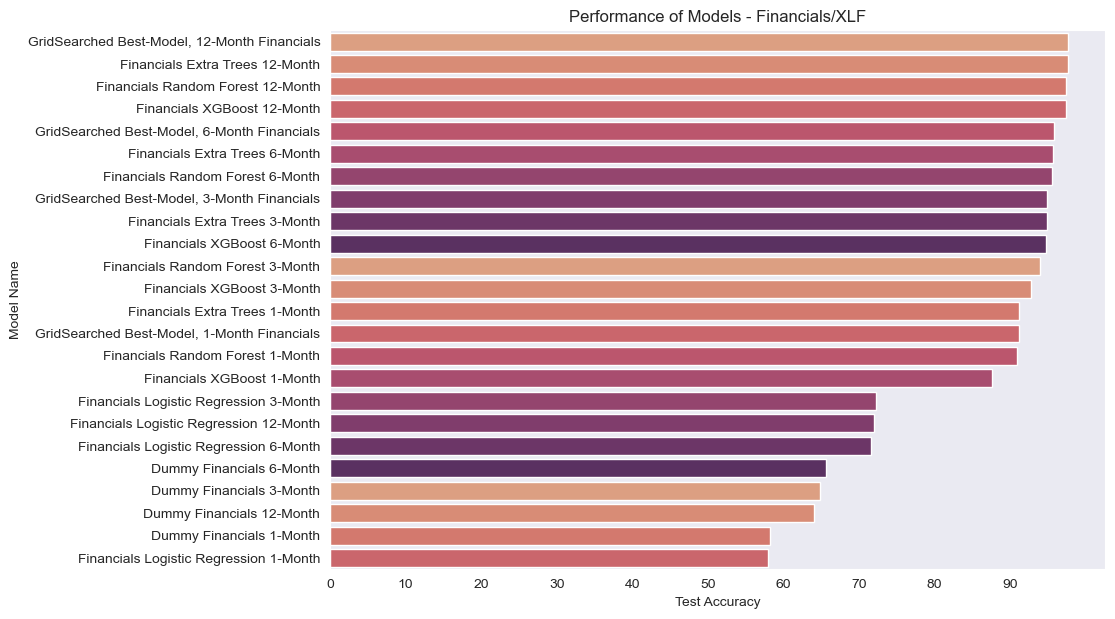

In [101]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Financials_df, "Financials/XLF", num_include=30)

In [102]:
# These were the models with the highest accuracy score for this ETF

Financials_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Financials",0.976192,0.981960,0.980522,0.981217,0.080634,0.977104,0.985185,0.978970,0.982068,0.069402,0.997412
21,Financials Extra Trees 12-Month,0.974618,0.980877,0.979104,0.979958,0.078537,0.977104,0.987248,0.976866,0.982030,0.069397,0.997436
20,Financials Random Forest 12-Month,0.972148,0.979096,0.976980,0.978013,0.102726,0.974411,0.983069,0.976866,0.979958,0.089078,0.996172
22,Financials XGBoost 12-Month,0.969004,0.975951,0.975210,0.975552,0.087966,0.973737,0.975992,0.983176,0.979570,0.080545,0.996178
17,"GridSearched Best-Model, 6-Month Financials",0.963614,0.972341,0.970265,0.971278,0.153263,0.958923,0.969231,0.968238,0.968734,0.099020,0.994469


### How did our model perform when predicting "BUY"?
The best model was a 12-month model, again, based on the ExtraTreesClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 16.8%. The worst outcome on a predicted "buy" was a loss of 4.5%.` 

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,945.000000,945.000000,945.000000,945.000000
mean,0.017345,0.051127,0.108205,0.202729
std,0.071478,0.100923,0.126003,0.165032
min,-0.391374,-0.410879,-0.227346,-0.040453
25%,-0.012021,0.006265,0.038519,0.090838
50%,0.019877,0.047992,0.090122,0.168316
75%,0.050449,0.099444,0.164468,0.267502
max,0.415218,0.822159,1.095311,1.214940


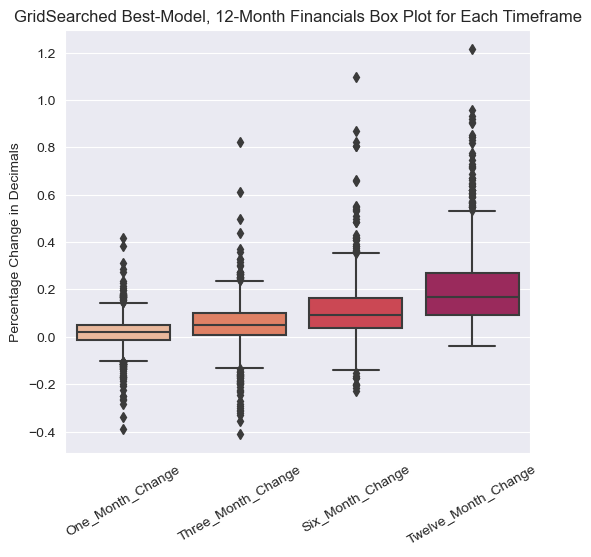

In [103]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Financials[23], "XLF", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

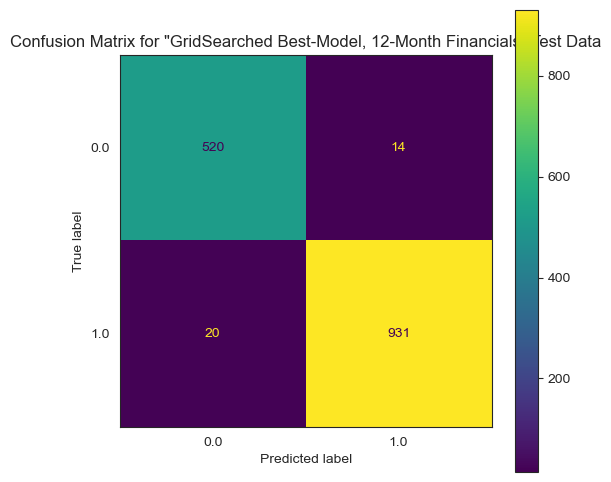

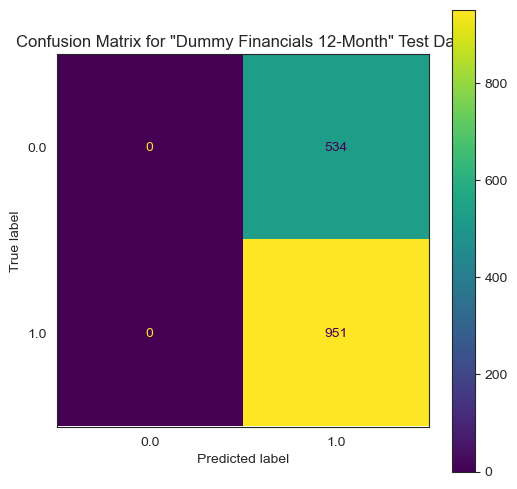

In [104]:
# Shows the best model's predictions and the dummy for that particular time horizon
Financials[23].confusion_matrix(), Financials[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [105]:
# Feature Importances for each time-horizon's best model
print_feature_importances(8, 12, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
Close                    0.043673
one_up_bollinger_band    0.041729
MACD                     0.041459
20_day_SMA               0.041107
Adj Close                0.040444
Name: Financials 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.059457
Interest_Rates          0.050008
ATR                     0.045765
upper_bollinger_band    0.041875
High                    0.040555
Name: Financials 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled               0.070846
Interest_Rates           0.062236
one_up_bollinger_band    0.045323
lower_bollinger_band     0.042885
20_day_SMA               0.042699
Name: Financials 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled               0.070805
cycle_year_3             0.054050
Interest_Rates          

<hr style="border: 4px solid black">

# Industrials XLI

Once again, the further out into the future our predictions, the more accurate our models became. The short term- technical indicators, longer term macro-economic trends continued. Our best model was again a 12 month model. The worst outcome was a `3% loss` and the best outcome was a `96.7% gain.`

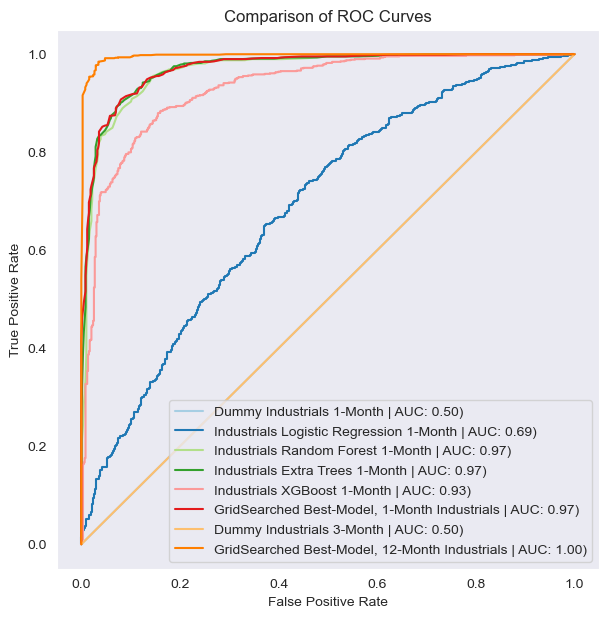

In [106]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Industrials[0], Industrials[1], Industrials[2],Industrials[3],Industrials[4],Industrials[5], \
                Industrials[6], Industrials[23]])

# 23 was the best model of this sector

### Best Models for the Sector

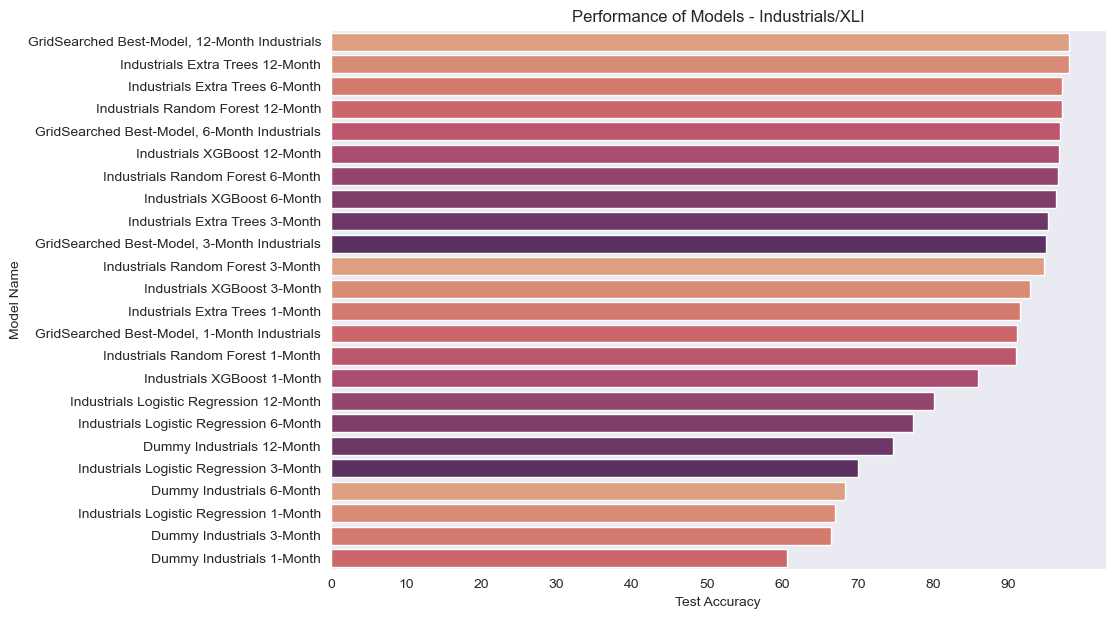

In [107]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Industrials_df, "Industrials/XLI", num_include=30)

In [108]:
# These were the models with the highest accuracy score for this ETF

Industrials_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Industrials",0.974617,0.978553,0.987655,0.983066,0.087366,0.980471,0.982159,0.991892,0.987001,0.067330,0.996659
21,Industrials Extra Trees 12-Month,0.974617,0.978553,0.987655,0.983066,0.087366,0.980471,0.982159,0.991892,0.987001,0.067330,0.996659
15,Industrials Extra Trees 6-Month,0.958672,0.968772,0.970023,0.969375,0.130954,0.971717,0.976471,0.982249,0.979351,0.109122,0.994059
20,Industrials Random Forest 12-Month,0.968328,0.971598,0.986450,0.978936,0.109630,0.971717,0.978495,0.983784,0.981132,0.086344,0.995852
17,"GridSearched Best-Model, 6-Month Industrials",0.960245,0.969805,0.971354,0.970553,0.123504,0.969024,0.975442,0.979290,0.977362,0.087530,0.995223


### How did our model perform when predicting "BUY"?
The best model was a 12-month model, based on the ExtraTreesClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 15.8%. The worst outcome on a predicted "buy" was a loss of 3%.`

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1121.000000,1121.000000,1121.000000,1121.000000
mean,0.015909,0.045698,0.088714,0.176382
std,0.056540,0.082544,0.108977,0.134125
min,-0.388168,-0.368861,-0.288918,-0.029680
25%,-0.010410,0.001103,0.025240,0.082980
50%,0.017842,0.047559,0.088253,0.157895
75%,0.046565,0.094275,0.149537,0.242551
max,0.252409,0.457482,0.578211,0.966705


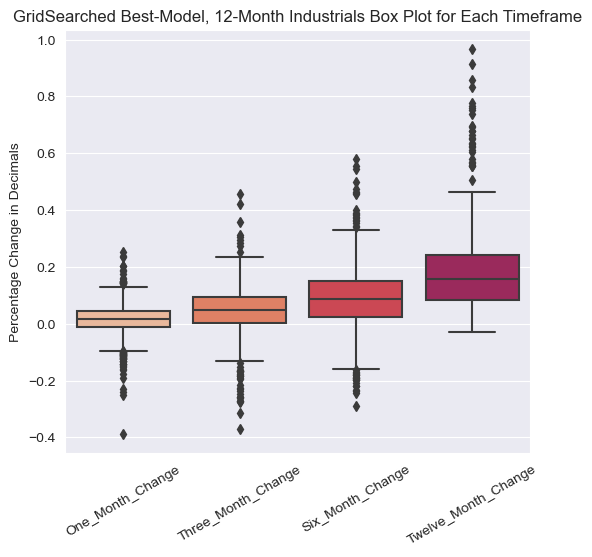

In [109]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Industrials[23], "XLI", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

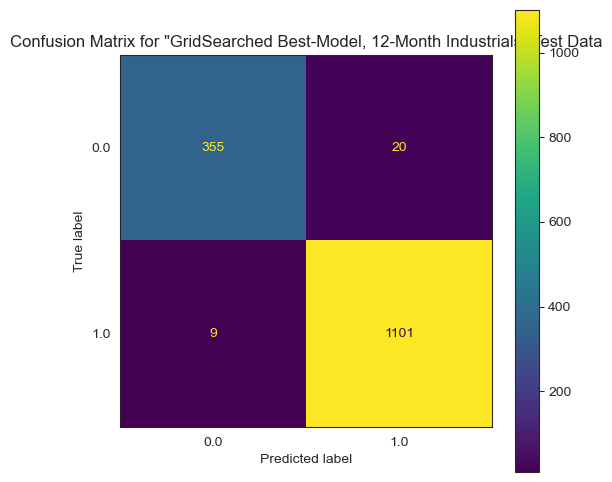

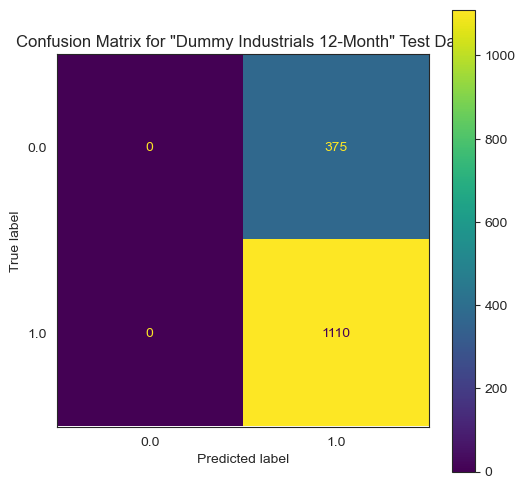

In [110]:
# Shows the best model's predictions and the dummy for that particular time horizon
Industrials[23].confusion_matrix(), Industrials[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [111]:
# Feature Importances for each time-horizon's best model
print_feature_importances(12, 16, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
one_up_bollinger_band    0.043751
20_day_SMA               0.043720
Adj Close                0.043372
Close                    0.043301
lowest_bollinger_band    0.042839
Name: Industrials 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled               0.049544
Interest_Rates           0.049392
one_up_bollinger_band    0.041404
lower_bollinger_band     0.040421
lowest_bollinger_band    0.040274
Name: Industrials 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.070269
Interest_Rates          0.061267
Adj Close               0.041869
20_day_SMA              0.041867
lower_bollinger_band    0.041442
Name: Industrials 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.080886
Interest_Rates          0.064420
garman_klass_vol       

<hr style="border: 4px solid black">

# Technology XLK

This is the first sector to have a 3-Month model perform the best for the sector. Other interesting observations are that GDP and Interest Rates have a significantly amplified importance on longer-term returns. The importances of: `Interest Rates 0.089 GDP 0.107 for 12-Month best model` are the quite high relative importances. Garman-Klass Volatility and ATR are top 5 in 3 out of 4 time categories, and both of those factors measure volatility. For our 12-month model, `the worst outcome on a predicted "buy" was a loss of 2` and the `largest gain was 88%.`

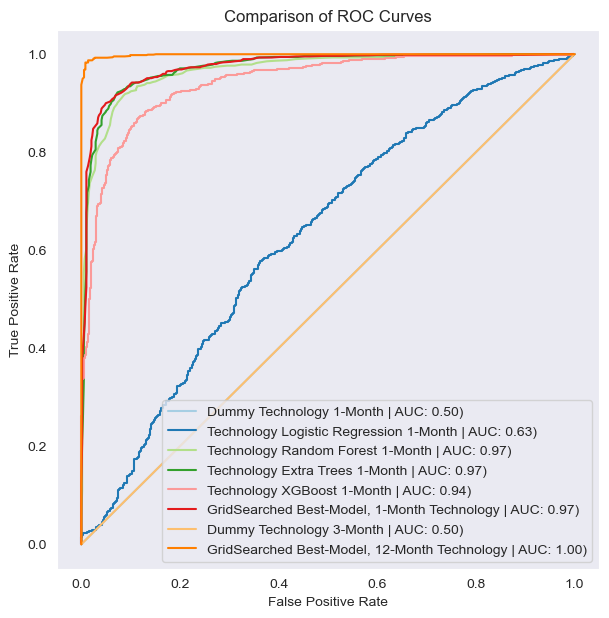

In [112]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Technology[0], Technology[1], Technology[2],Technology[3],Technology[4],Technology[5], \
                Technology[6], Technology[23]])

# 23 was the best model of this sector

### Best Models for the Sector

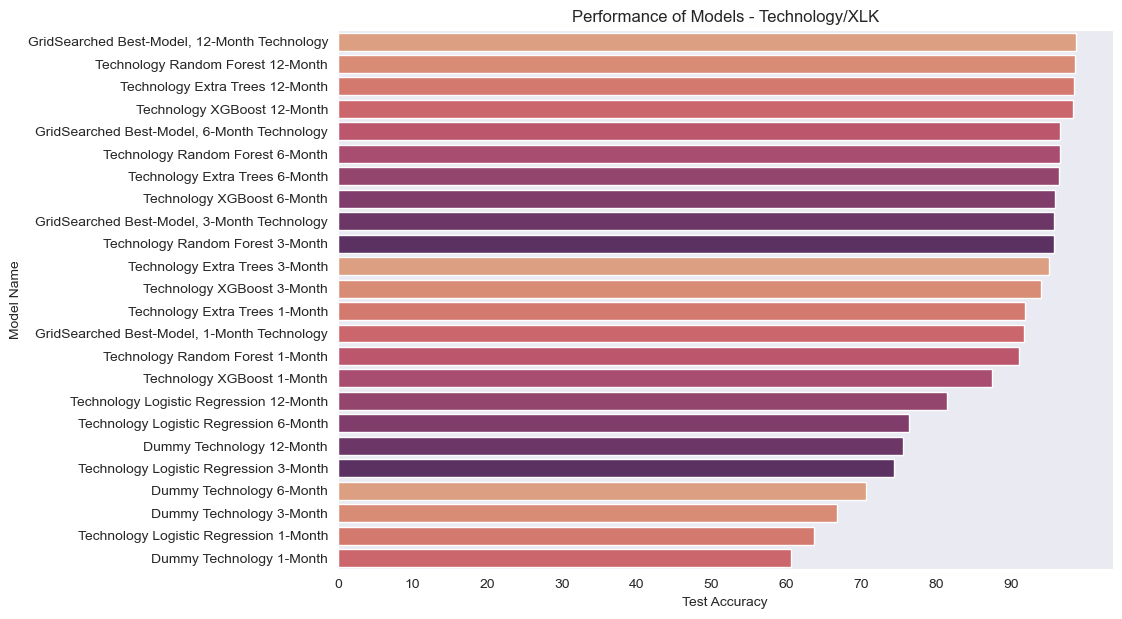

In [113]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Technology_df, "Technology/XLK", num_include=30)

In [114]:
# These were the models with the highest accuracy score for this ETF

Technology_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Technology",0.980231,0.981350,0.992506,0.986880,0.084918,0.987205,0.990222,0.992870,0.991544,0.052344,0.998891
20,Technology Random Forest 12-Month,0.978434,0.979596,0.991907,0.985694,0.077740,0.986532,0.990214,0.991979,0.991095,0.051671,0.998922
21,Technology Extra Trees 12-Month,0.980008,0.984525,0.988911,0.986693,0.072815,0.984512,0.988444,0.991087,0.989764,0.042637,0.999099
22,Technology XGBoost 12-Month,0.977761,0.982164,0.988311,0.985211,0.086091,0.983838,0.986702,0.991979,0.989333,0.054686,0.995889
17,"GridSearched Best-Model, 6-Month Technology",0.966305,0.970524,0.981193,0.975822,0.123413,0.965657,0.972538,0.979028,0.975772,0.102938,0.994773


### How did our model perform when predicting "BUY"?
The best model was a 12-month model, based on the RandomForestClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 19.1%. The worst outcome on a predicted "buy" was a loss of 2.1%.`

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1125.000000,1125.000000,1125.000000,1125.000000
mean,0.015763,0.050944,0.107542,0.214783
std,0.060171,0.088185,0.108252,0.147210
min,-0.297877,-0.264152,-0.289942,-0.020982
25%,-0.014511,0.005800,0.039108,0.101288
50%,0.020528,0.051303,0.098532,0.191351
75%,0.047680,0.097875,0.162519,0.295962
max,0.309666,0.490317,0.590447,0.879086


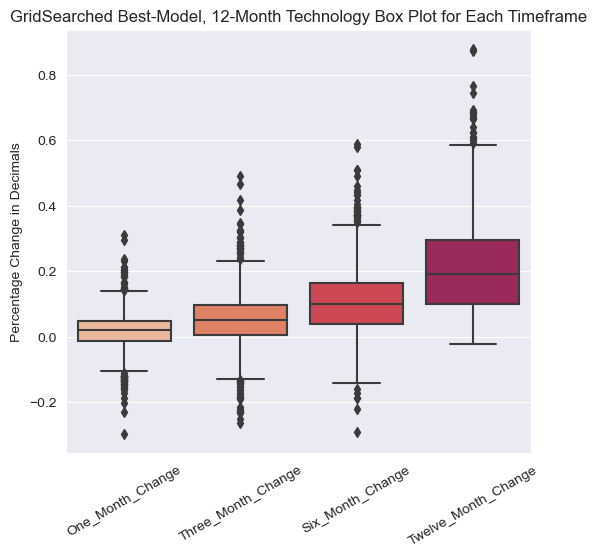

In [115]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Technology[23], "XLK", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

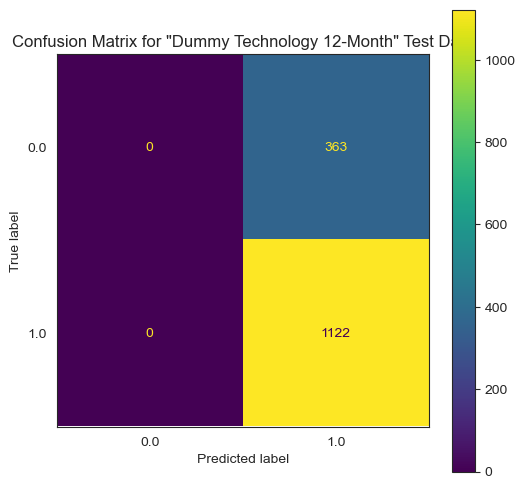

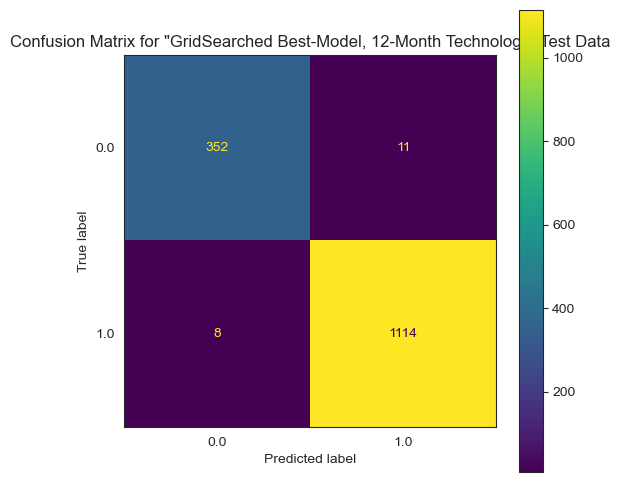

In [116]:
# Shows the best model's predictions and the dummy for that particular time horizon
Technology[18].confusion_matrix(), Technology[23].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [117]:
# Feature Importances for each time-horizon's best model
print_feature_importances(16, 20, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
Interest_Rates           0.043987
Close                    0.040796
Adj Close                0.040642
lowest_bollinger_band    0.040601
High                     0.040307
Name: Technology 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.082286
Interest_Rates          0.077820
ATR                     0.060027
upper_bollinger_band    0.051168
Adj Close               0.044271
Name: Technology 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.111760
Interest_Rates          0.088981
ATR                     0.053643
Close                   0.048921
upper_bollinger_band    0.048667
Name: Technology 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled          0.107027
Interest_Rates      0.089497
garman_klass_vol    0.063715
High      

<hr style="border: 4px solid black">

# Staples XLP

We are back to longterm predictions being the most accurate. The sector's best model was a 12 month model. The `largest loss on "buy" predictions was 2.3%` and the largest 12-Month `gain for this sector is around 41.6%` which is quite a small number compared to other sectors. This is an area to invest in if you want to experience relatively low volatility and reap steady dividends. 

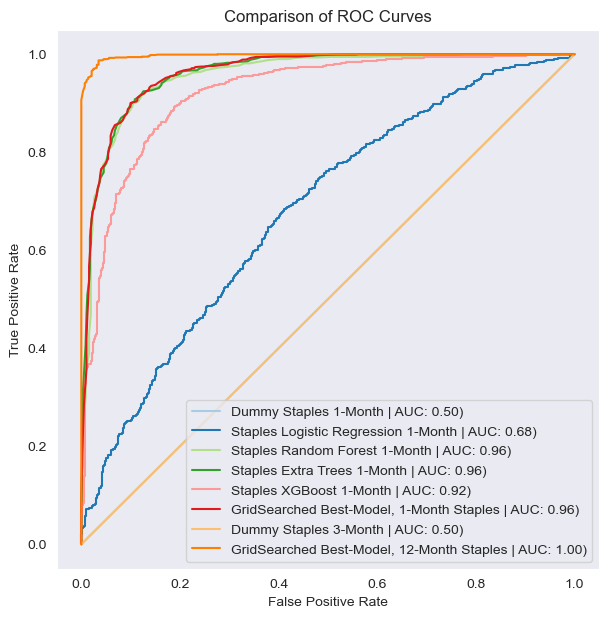

In [118]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Staples[0], Staples[1], Staples[2],Staples[3],Staples[4],Staples[5], \
                Staples[6], Staples[23]])

# 23 was the best model of this sector

### Best Models for the Sector

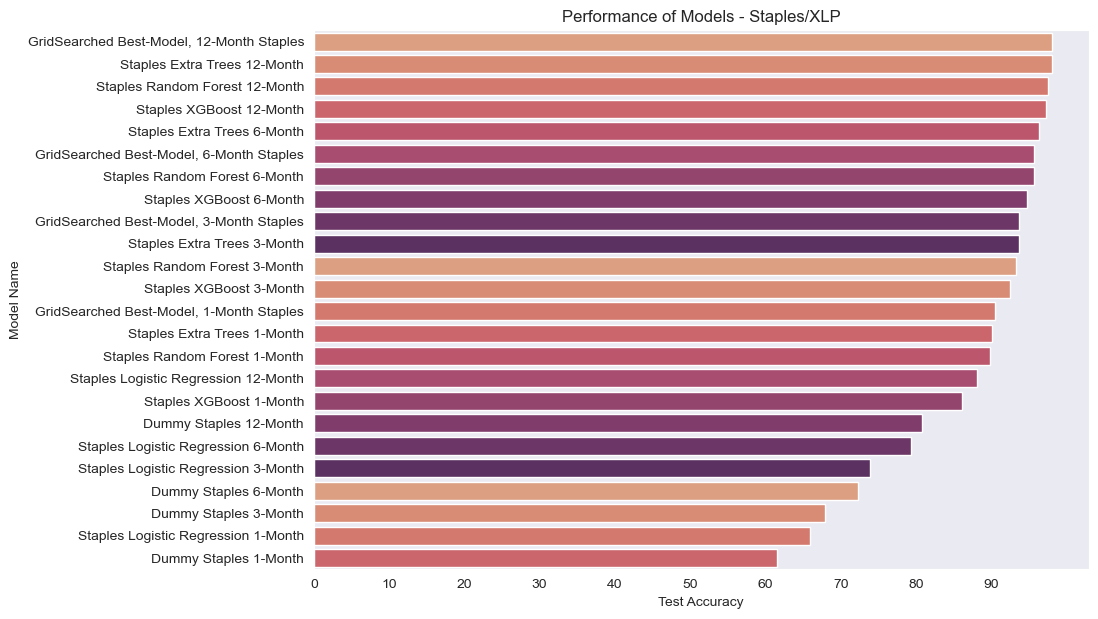

In [119]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Staples_df, "Staples/XLP", num_include=30)

In [120]:
# These were the models with the highest accuracy score for this ETF

Staples_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Staples",0.977313,0.984189,0.988223,0.986197,0.089298,0.980471,0.982673,0.993328,0.987972,0.056970,0.997498
21,Staples Extra Trees 12-Month,0.977313,0.984189,0.988223,0.986197,0.089298,0.980471,0.982673,0.993328,0.987972,0.056970,0.997498
20,Staples Random Forest 12-Month,0.975966,0.982589,0.988223,0.985390,0.072484,0.975758,0.977814,0.992494,0.985099,0.070672,0.996041
22,Staples XGBoost 12-Month,0.969901,0.978266,0.985209,0.981716,0.092897,0.972391,0.973813,0.992494,0.983065,0.077629,0.995375
15,Staples Extra Trees 6-Month,0.952830,0.963514,0.973385,0.968410,0.130524,0.962963,0.964416,0.985089,0.974643,0.136564,0.988749


### How did our model perform when predicting "BUY"?
The best model was a 12-month model, based on the ExtraTreesClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 11.3%. The worst outcome on a predicted "buy" was a loss of 2.3%.` Fairly dull, and relatively unappealing upside potentital, but steady. Still, with other sector recommendations managing to limit downside risk, the case for investing here is a bit difficult to make.

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1212.000000,1212.000000,1212.000000,1212.000000
mean,0.009748,0.028788,0.057589,0.117312
std,0.036454,0.053405,0.062212,0.072007
min,-0.219089,-0.217773,-0.126493,-0.023259
25%,-0.008215,0.000040,0.014360,0.062047
50%,0.012152,0.030535,0.057740,0.112658
75%,0.030869,0.062407,0.097662,0.160705
max,0.194530,0.220625,0.297731,0.416064


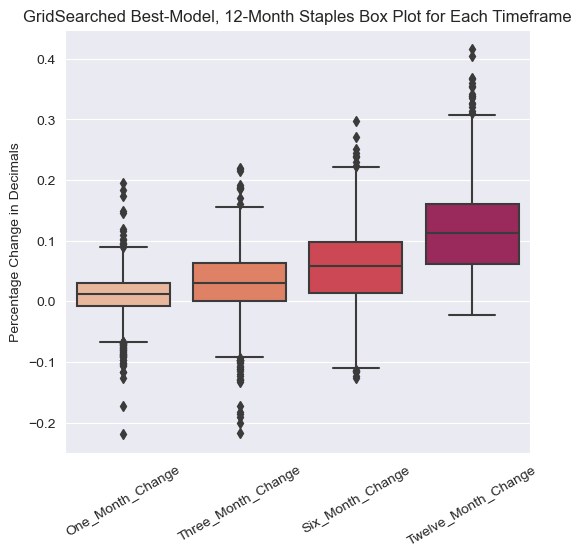

In [121]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Staples[23], "XLP", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

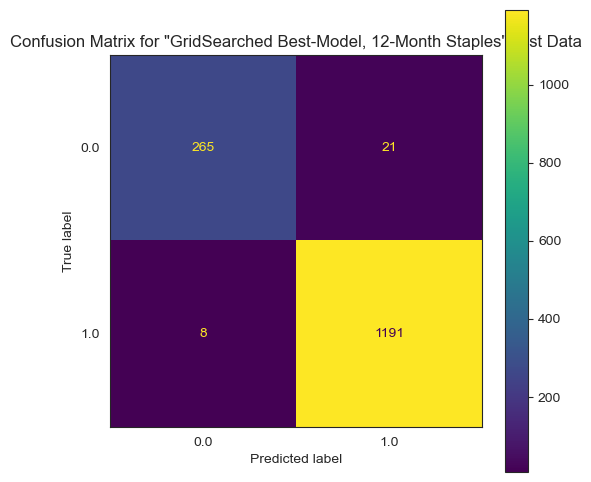

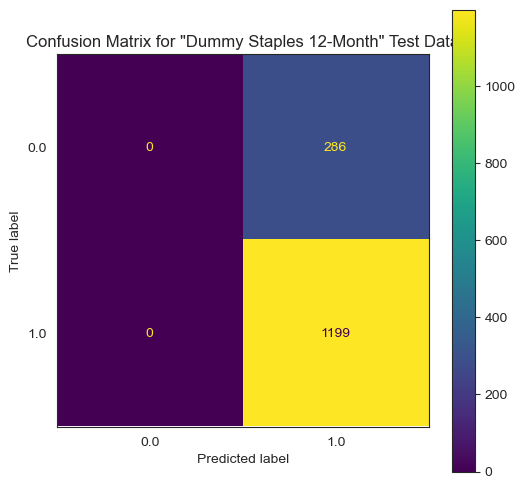

In [122]:
# Shows the best model's predictions and the dummy for that particular time horizon
Staples[23].confusion_matrix(), Staples[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [123]:
# Feature Importances for each time-horizon's best model
print_feature_importances(20, 24, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
one_up_bollinger_band    0.046321
20_day_SMA               0.044469
lower_bollinger_band     0.044290
upper_bollinger_band     0.043701
lowest_bollinger_band    0.043340
Name: Staples 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest_Rates          0.051740
GDP_Filled              0.050704
High                    0.044765
20_day_SMA              0.042052
lower_bollinger_band    0.041497
Name: Staples 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.067432
Interest_Rates          0.062814
ATR                     0.045158
garman_klass_vol        0.042538
lower_bollinger_band    0.041215
Name: Staples 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled          0.091514
garman_klass_vol    0.066628
Interest_Rates      0.065282
Close              

<hr style="border: 4px solid black">

# Utilities XLU

The best model for this sector was again a 12-month model. The `largest 6-month gain was around 44%,` and the `largest loss was 9.7%.` This is another area to invest in if you want to experience relatively low volatility and reap steady dividends, however this 9.7% loss represents the largest loss on a buy prediction so far. 

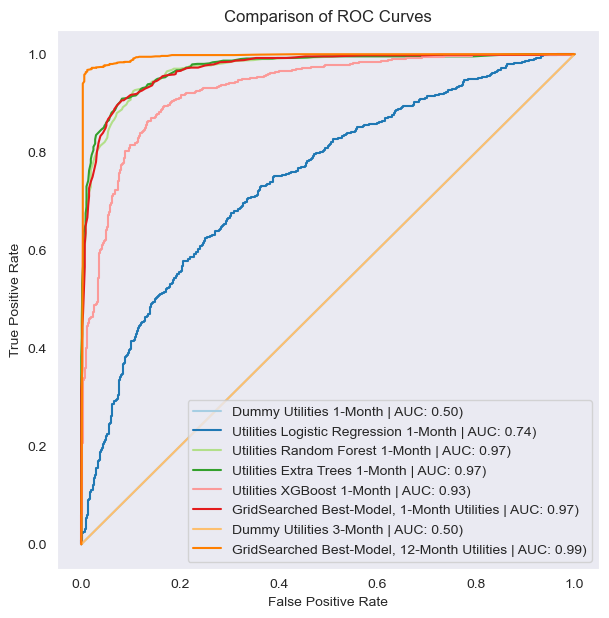

In [124]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Utilities[0], Utilities[1], Utilities[2],Utilities[3],Utilities[4],Utilities[5], \
                Utilities[6], Utilities[23]])

# 23 was the best model of this sector

### Best Models for the Sector

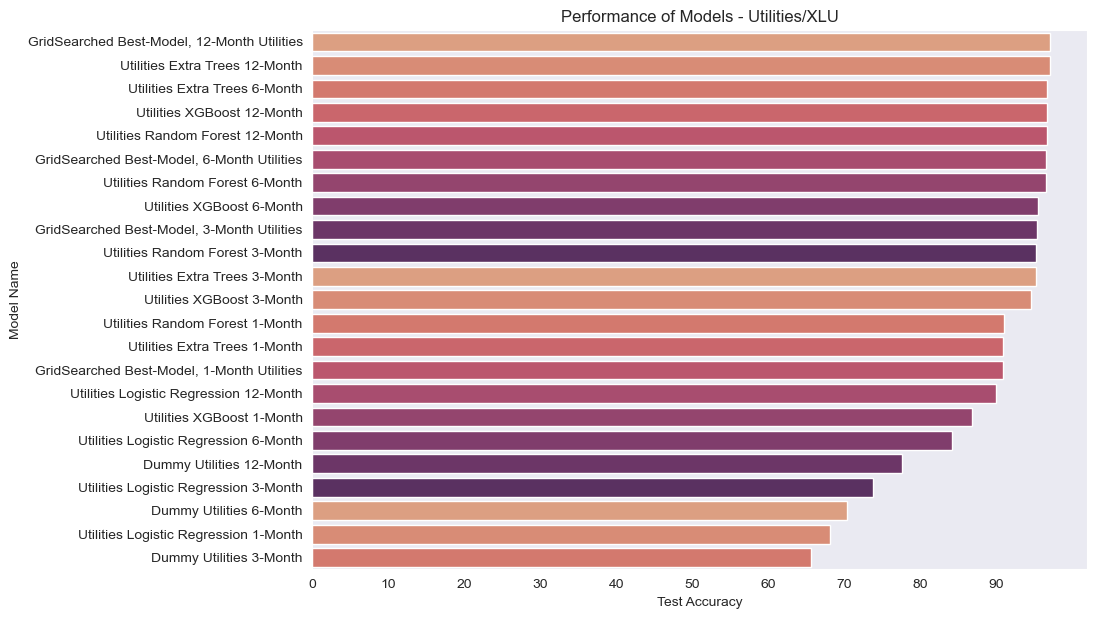

In [125]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Utilities_df, "Utilities/XLU", num_include=-1)

In [126]:
# These were the models with the highest accuracy score for this ETF

Utilities_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Utilities",0.977538,0.984921,0.986047,0.985477,0.078892,0.971717,0.983464,0.980052,0.981755,0.087481,0.994842
21,Utilities Extra Trees 12-Month,0.975515,0.983470,0.984884,0.984168,0.078756,0.971717,0.982624,0.980919,0.981771,0.085716,0.995115
15,Utilities Extra Trees 6-Month,0.965634,0.974588,0.977287,0.975913,0.108074,0.967677,0.975214,0.978947,0.977077,0.092534,0.994655
22,Utilities XGBoost 12-Month,0.972370,0.980588,0.983721,0.982145,0.093864,0.967677,0.980017,0.978317,0.979167,0.105650,0.993388
20,Utilities Random Forest 12-Month,0.974168,0.979524,0.987209,0.983348,0.092117,0.967003,0.978336,0.979185,0.978760,0.097258,0.994257


### How did our model perform when predicting "BUY"?
The best model was a 12-month model, based on the ExtraTreesClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 14.1%. The worst outcome on a predicted "buy" was a loss of 9.7%.` This might be the largest outlier loss on a 'buy' prediction.

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1149.000000,1149.000000,1149.000000,1149.000000
mean,0.012110,0.038207,0.074302,0.151642
std,0.043907,0.065189,0.075154,0.090602
min,-0.201112,-0.239707,-0.169531,-0.097411
25%,-0.010704,-0.000025,0.027708,0.089497
50%,0.014574,0.040008,0.072205,0.141050
75%,0.036115,0.075336,0.123553,0.202059
max,0.290007,0.304150,0.293176,0.438948


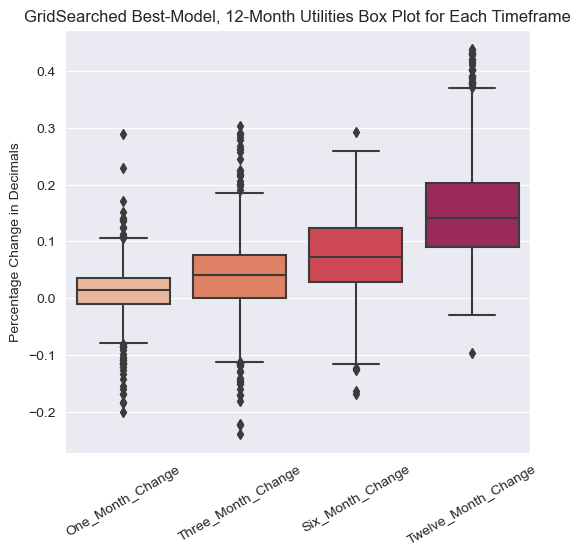

In [127]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Utilities[23], "XLU", cat=1, box=True)

In [153]:
# Tracking down the outlier, to find that it was a year out from the Pandemic crash
change = Utilities[23].X_test.join(df[df["Ticker"] == "XLU"]["Twelve_Month_Change"])
change['preds'] =  Utilities[23].y_pred
change[change['preds'] == 1][["Twelve_Month_Change", "preds"]].sort_values(by="Twelve_Month_Change")[:5]

,Twelve_Month_Change,preds
Date,,
2019-03-14,-0.097411,1.0
2019-05-13,-0.029934,1.0
2019-06-21,-0.023665,1.0
2019-06-19,-0.023133,1.0
2007-07-18,-0.020457,1.0


### Comparison of Dummy Confusion Matrix to the Best Model

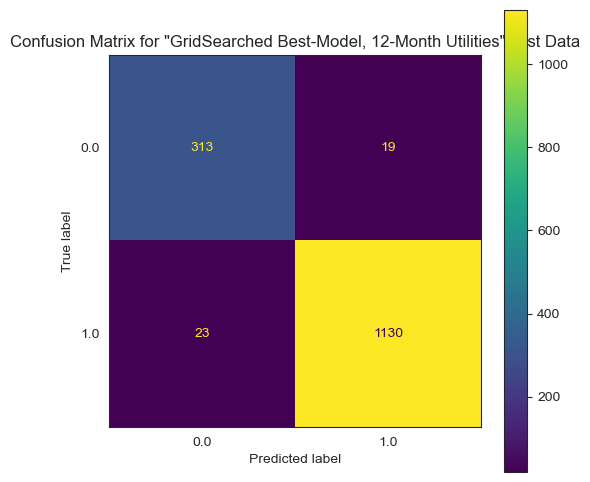

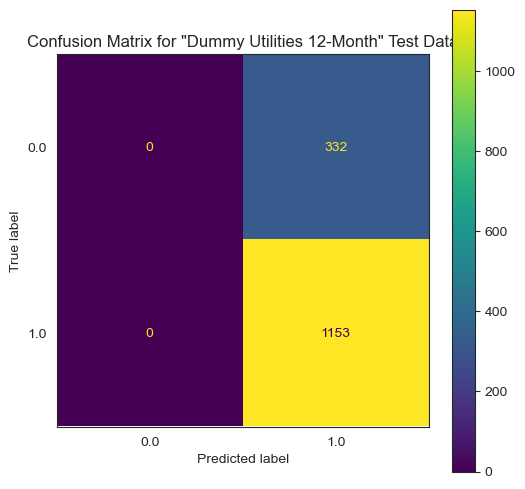

In [154]:
# Shows the best model's predictions and the dummy for that particular time horizon
Utilities[23].confusion_matrix(), Utilities[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [155]:
# Feature Importances for each time-horizon's best model
print_feature_importances(24, 28, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
MACD                     0.044034
lower_bollinger_band     0.043549
upper_bollinger_band     0.042370
20_day_SMA               0.042313
lowest_bollinger_band    0.042276
Name: Utilities 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled               0.061653
Interest_Rates           0.055743
garman_klass_vol         0.051197
one_up_bollinger_band    0.049369
ATR                      0.048428
Name: Utilities 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.062384
Interest_Rates          0.060243
garman_klass_vol        0.048690
lower_bollinger_band    0.044345
High                    0.043419
Name: Utilities 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.083177
Interest_Rates          0.082225
garman_klass_vol        0.079

<hr style="border: 4px solid black">

# Health Care XLV

Feature importance trends continue to be in place, with GDP and Interest Rates dominating longer term timeframes.  
`Median 12-Month returns on positive predictions were 11.4%,` with the `worst outcome being a 2.8% loss.` The best model was 96.6% accurate on unseen data. `Maximum 12-Month gains were 56%.`

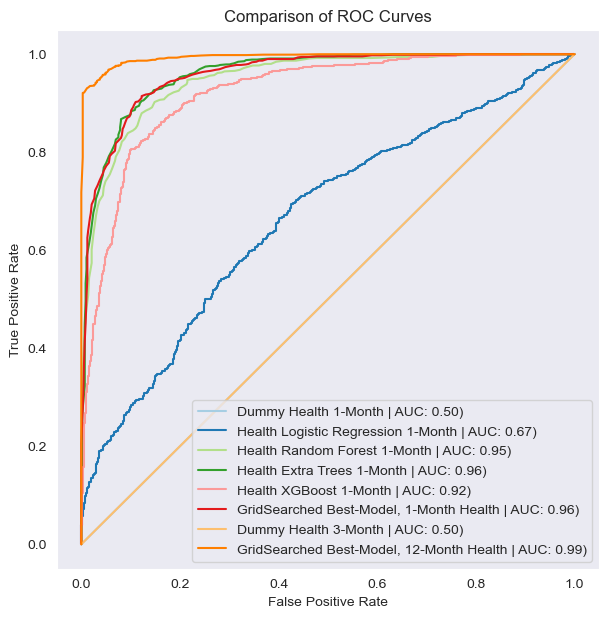

In [156]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Health[0], Health[1], Health[2],Health[3],Health[4],Health[5], \
                Health[6], Health[23]])

# 23 was the best model of this sector

### Best Models for the Sector

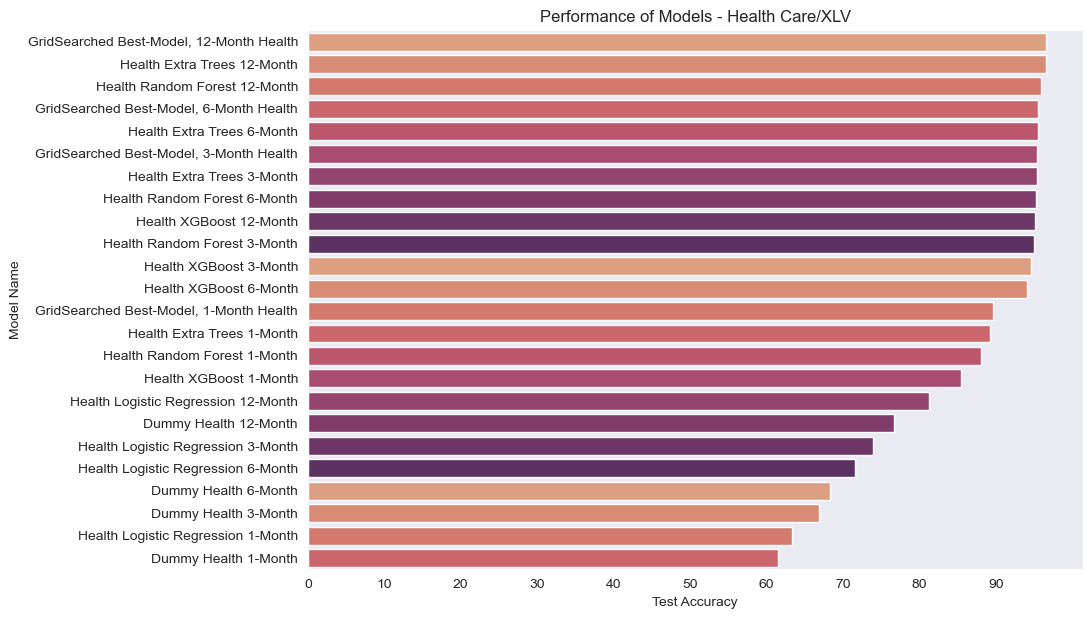

In [157]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Health_df, "Health Care/XLV", num_include=30)

In [158]:
# These were the models with the highest accuracy score for this ETF

Health_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Health",0.969901,0.979293,0.981573,0.980427,0.103660,0.965657,0.978873,0.976295,0.977582,0.090834,0.993823
21,Health Extra Trees 12-Month,0.969901,0.979293,0.981573,0.980427,0.103660,0.965657,0.978873,0.976295,0.977582,0.090834,0.993823
20,Health Random Forest 12-Month,0.960692,0.972101,0.976892,0.974471,0.121046,0.959596,0.974494,0.972783,0.973638,0.108981,0.991947
17,"GridSearched Best-Model, 6-Month Health",0.946770,0.961885,0.960889,0.961368,0.151902,0.954882,0.957488,0.977318,0.967301,0.121576,0.992250
15,Health Extra Trees 6-Month,0.946770,0.961885,0.960889,0.961368,0.151902,0.954882,0.957488,0.977318,0.967301,0.121576,0.992250


### How did our model perform when predicting "BUY"?
The best model was a 12-month model grid tuned ExtraTreesClassifier. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 11.4%. The worst outcome on a predicted "buy" was a loss of 2.8%.`

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1136.000000,1136.000000,1136.000000,1136.000000
mean,0.013972,0.039342,0.072857,0.140095
std,0.045681,0.061398,0.078566,0.101238
min,-0.234885,-0.224878,-0.189957,-0.027809
25%,-0.008642,0.000643,0.019475,0.063289
50%,0.015689,0.043955,0.080481,0.113770
75%,0.039004,0.078901,0.123697,0.216501
max,0.326186,0.350780,0.376824,0.558839


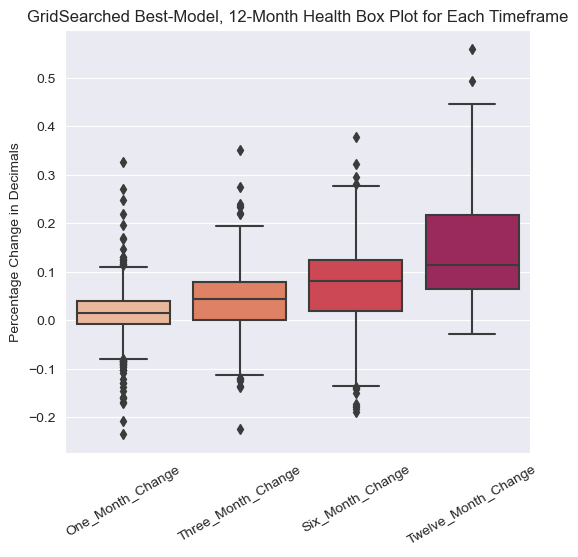

In [159]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Health[23], "XLV", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

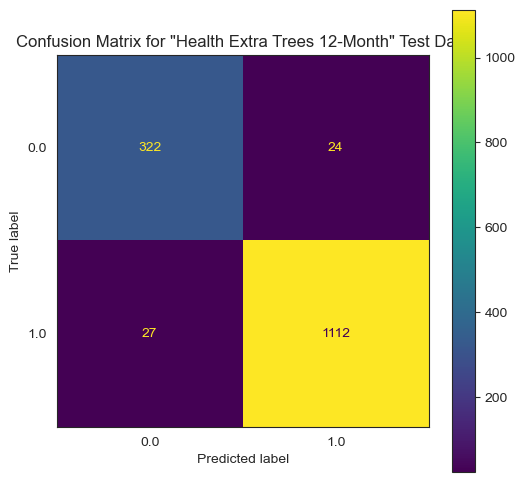

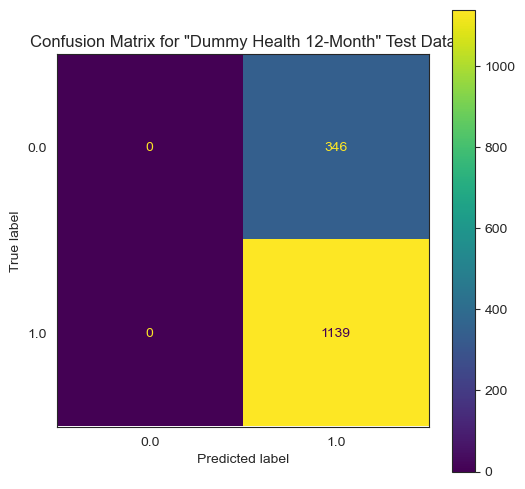

In [160]:
# Shows the best model's predictions and the dummy for that particular time horizon
Health[21].confusion_matrix(), Health[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [161]:
# Feature Importances for each time-horizon's best model
print_feature_importances(28, 32, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
one_up_bollinger_band    0.043397
20_day_SMA               0.043182
Adj Close                0.042893
MACD                     0.042090
High                     0.041518
Name: Health Care 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest_Rates           0.050984
GDP_Filled               0.048581
Adj Close                0.044605
one_up_bollinger_band    0.043603
upper_bollinger_band     0.042264
Name: Health Care 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled               0.059485
Interest_Rates           0.053887
Close                    0.048186
High                     0.045207
one_up_bollinger_band    0.043684
Name: Health Care 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest_Rates      0.089333
GDP_Filled          0.068722
garman_klass_vol    0.0509

<hr style="border: 4px solid black">

# Consumer Discretionary XLY

Feature importance of .115 for Interest Rates over 12-Month predictions is `AGAIN a new high value.` Interest Rates were also the most important feature for every time horizon, except 1-month where they were 2nd. This makes perfect logical sense, as when interest rates are lower, the costs of borrowing are lower,thereby incentivizing more consumer expenditures. `Median 12-Month returns on positive predictions were 16.5%,` with the `worst outcome being a 3.9% loss.` The `largest gain for a "buy" prediction over one year was 93%.` The best model was 98% accurate on unseen data, making this one of the best models overall.

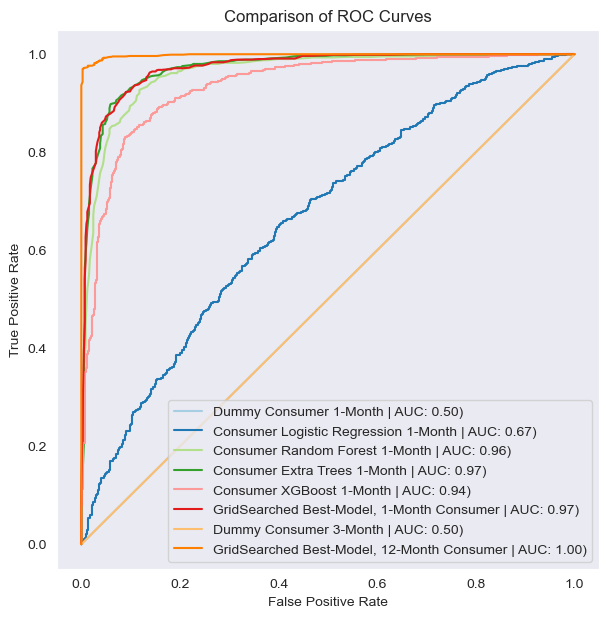

In [162]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Consumer_Disc[0], Consumer_Disc[1], Consumer_Disc[2],Consumer_Disc[3],Consumer_Disc[4],Consumer_Disc[5], \
                Consumer_Disc[6], Consumer_Disc[23]])

# 23 was the best model of this sector

### Best Models for the Sector

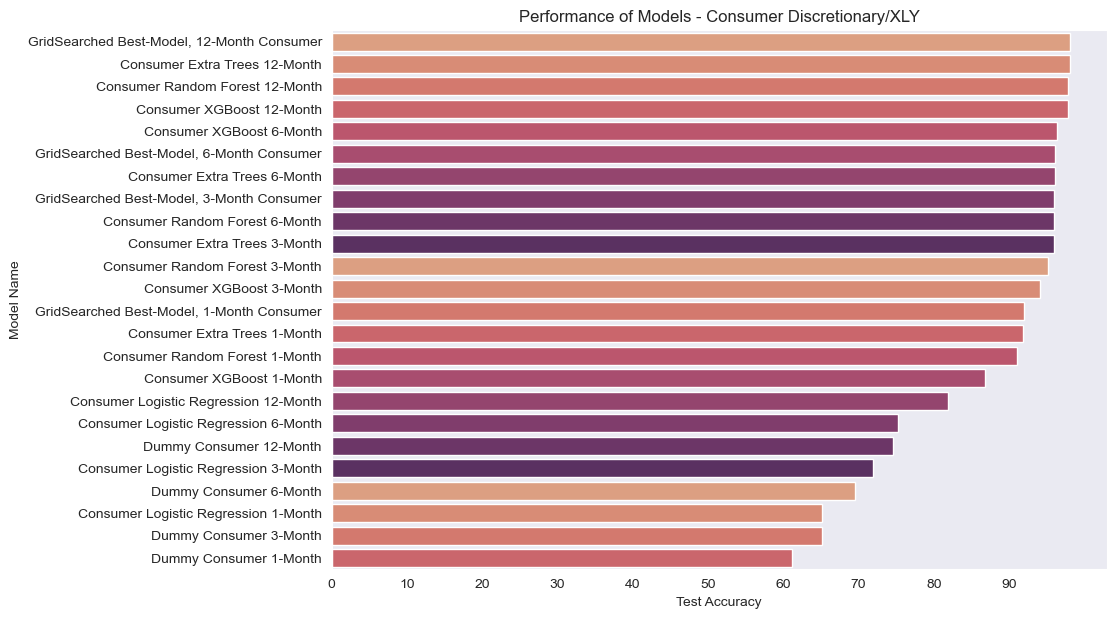

In [163]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Consumer_Disc_df, "Consumer Discretionary/XLY", num_include=30)

In [164]:
# These were the models with the highest accuracy score for this ETF

Consumer_Disc_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Consumer",0.978211,0.983310,0.987714,0.985493,0.071687,0.980471,0.988225,0.985547,0.986884,0.053408,0.998428
21,Consumer Extra Trees 12-Month,0.978211,0.983310,0.987714,0.985493,0.071687,0.980471,0.988225,0.985547,0.986884,0.053408,0.998428
20,Consumer Random Forest 12-Month,0.974391,0.979501,0.986517,0.982988,0.082246,0.978451,0.985547,0.985547,0.985547,0.065791,0.997834
22,Consumer XGBoost 12-Month,0.971248,0.976860,0.985021,0.980913,0.083995,0.977778,0.986413,0.983740,0.985075,0.076095,0.995338
16,Consumer XGBoost 6-Month,0.949683,0.960314,0.967109,0.963638,0.152271,0.962963,0.969290,0.977735,0.973494,0.130811,0.988424


### How did our model perform when predicting "BUY"?
The best model was a 12-month GridSearch tuned ExtraTreesClassifier. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 16.5%. The worst outcome on a predicted "buy" was a loss of 3.9%.`

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1104.000000,1104.000000,1104.000000,1104.000000
mean,0.015316,0.047683,0.093003,0.187882
std,0.057969,0.085741,0.110019,0.135647
min,-0.336382,-0.294982,-0.261885,-0.039298
25%,-0.013601,0.001686,0.022559,0.091864
50%,0.017404,0.047281,0.086814,0.164916
75%,0.046214,0.094878,0.153083,0.252399
max,0.274996,0.481793,0.657232,0.929438


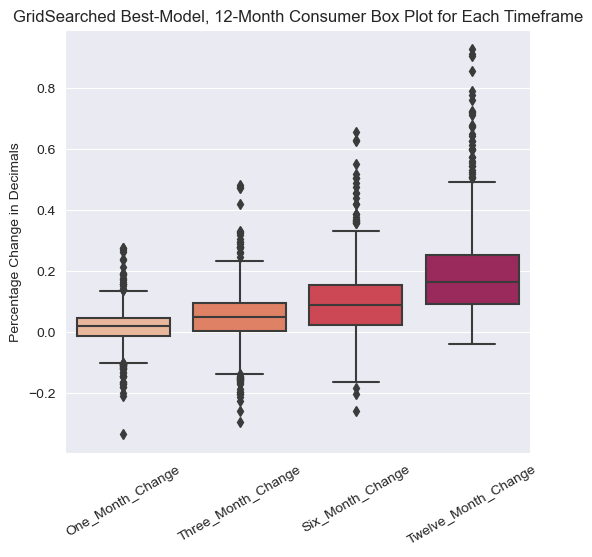

In [165]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Consumer_Disc[23], "XLY", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

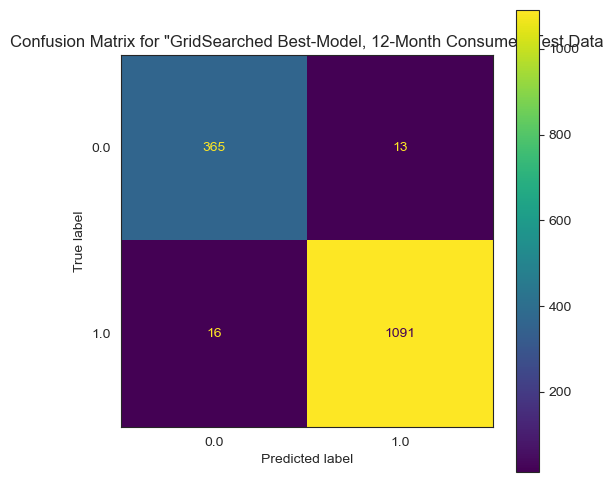

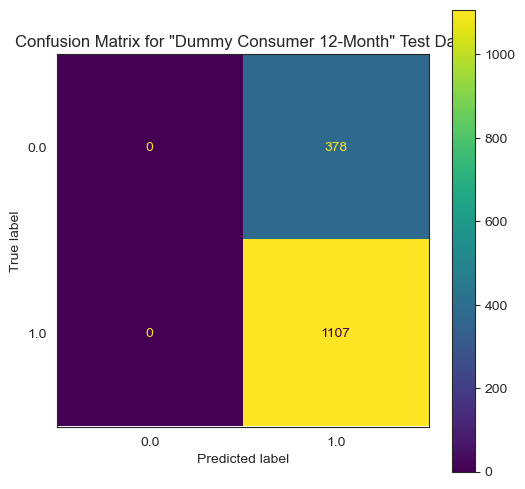

In [166]:
# Shows the best model's predictions and the dummy for that particular time horizon
Consumer_Disc[23].confusion_matrix(), Consumer_Disc[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [167]:
# Feature Importances for each time-horizon's best model
print_feature_importances(32, 36, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
20_day_SMA               0.044490
MACD                     0.044082
Interest_Rates           0.044034
Close                    0.042343
one_up_bollinger_band    0.042118
Name: Consumer Discretionary 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest_Rates          0.061267
GDP_Filled              0.049483
20_day_SMA              0.042596
lower_bollinger_band    0.040991
High                    0.040311
Name: Consumer Discretionary 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest_Rates          0.079677
GDP_Filled              0.059669
cycle_year_2            0.042587
lower_bollinger_band    0.041126
Close                   0.040850
Name: Consumer Discretionary 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest_Rates          0.114914
GDP_Filled              0.07

<hr style="border: 4px solid black">

# Real Estate XLRE

The Real Estate SPDR has only existed since October of 2015, so there is admitedly less data to parse for this sector. This is a rare occassion where a 6-month model was the best performer in this sector. This sector also had very atypical top feature importances for the 12 month time horizon, wherein neither GDP nor Interest Rates were found. Real Estate is considered to be another low volatility sector that pays dividends regularly. There have been exogenous shocks to this sector in the wake of Covid however, and the prevalence of "Work From Home" policies. With hybrid work becoming at least part of the new work pardigm, the future of commercial real estate is somewhat hazy. The `largest 6 Month gain on positive predictions was roughly 35%` and the `largest loss on a "buy" prediction was 1.2%.` Again, the models have performed well at minimizing losses when incorrect.

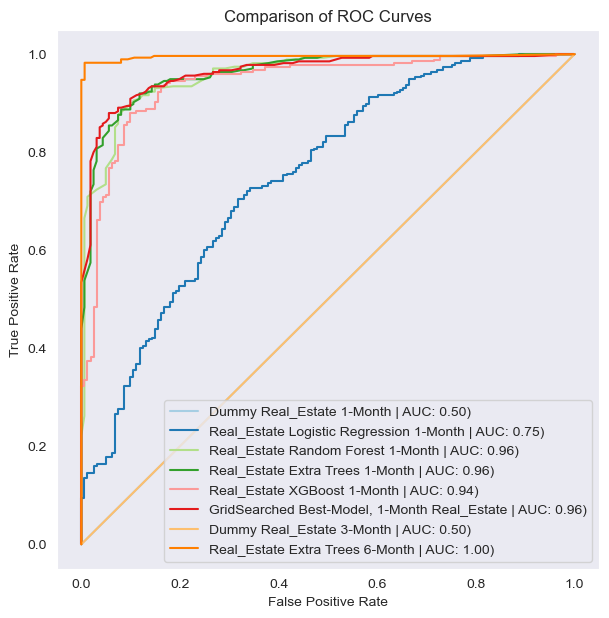

In [168]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Real_Estate[0], Real_Estate[1], Real_Estate[2],Real_Estate[3],Real_Estate[4],Real_Estate[5], \
                Real_Estate[6], Real_Estate[15]])

# 15 was the best model of this sector

### Best Models for the Sector

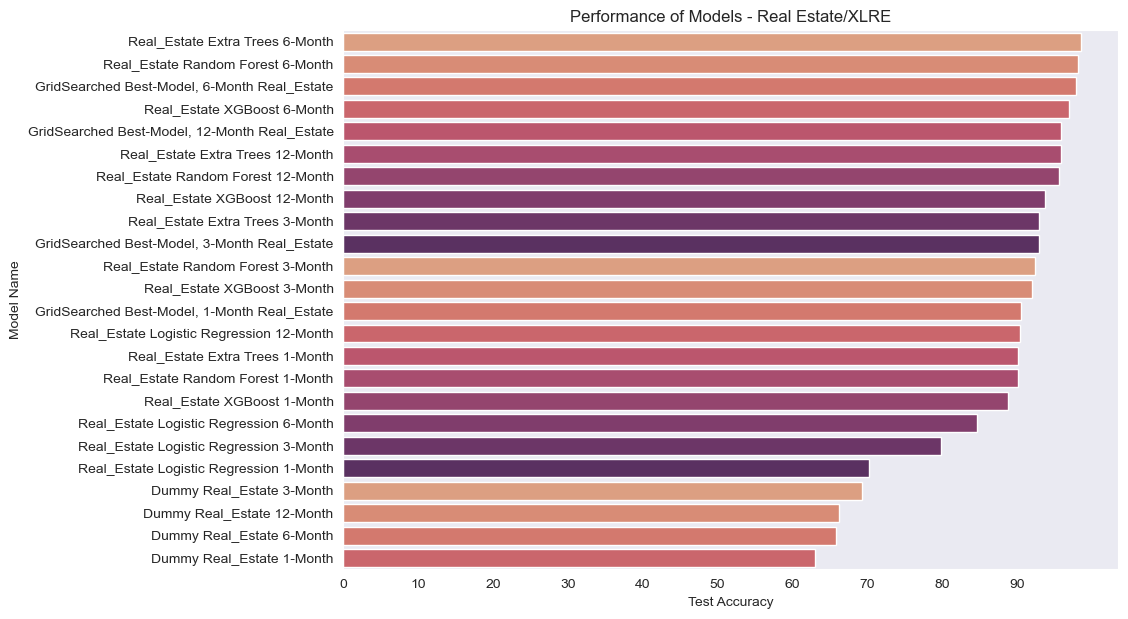

In [169]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Real_Estate_df, "Real Estate/XLRE", num_include=30)

In [170]:
# These were the models with the highest accuracy score for this ETF

Real_Estate_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,Real_Estate Extra Trees 6-Month,0.969419,0.977478,0.974914,0.976106,0.095903,0.986239,0.996466,0.982578,0.989474,0.143288,0.995300
14,Real_Estate Random Forest 6-Month,0.964061,0.971785,0.972512,0.971971,0.108880,0.981651,0.992933,0.979094,0.985965,0.089284,0.994306
17,"GridSearched Best-Model, 6-Month Real_Estate",0.971712,0.977536,0.978500,0.977951,0.118885,0.979358,0.989437,0.979094,0.984238,0.070450,0.995884
16,Real_Estate XGBoost 6-Month,0.963294,0.969414,0.973710,0.971439,0.134101,0.970183,0.979021,0.975610,0.977312,0.098037,0.993218
23,"GridSearched Best-Model, 12-Month Real_Estate",0.968670,0.982804,0.966444,0.974291,0.128038,0.958716,0.968858,0.968858,0.968858,0.119357,0.989666


### How did our model perform when predicting "BUY"?
The best model was a 6-month ExtraTreesClassifier. As you can see below, looking only at the "Six_Month_Change" column, the `median return on predicted "buys" for 6-Months was 9%. The worst outcome on a predicted "buy" was a loss of 1.2%.` `That loss was LITERALLY the only false positive made by the model.`

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,283.000000,283.000000,283.000000,283.000000
mean,0.020398,0.057235,0.110647,0.155254
std,0.045036,0.057896,0.072271,0.151451
min,-0.112475,-0.071988,-0.012052,-0.244499
25%,-0.005718,0.024880,0.058976,0.027659
50%,0.021437,0.047502,0.090572,0.182411
75%,0.043032,0.083499,0.145317,0.267094
max,0.294580,0.379349,0.347834,0.580571


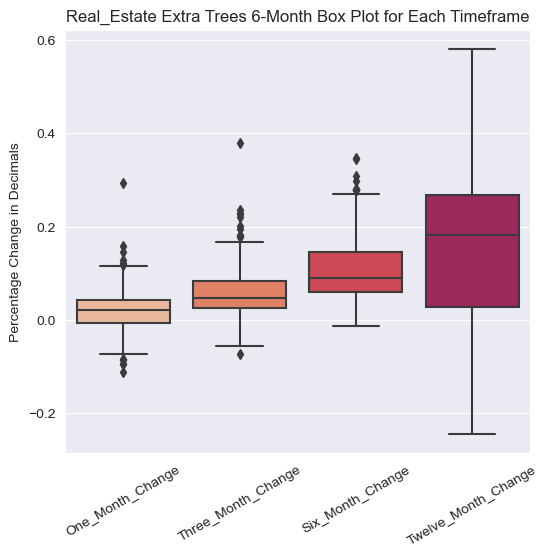

In [171]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Real_Estate[15], "XLRE", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

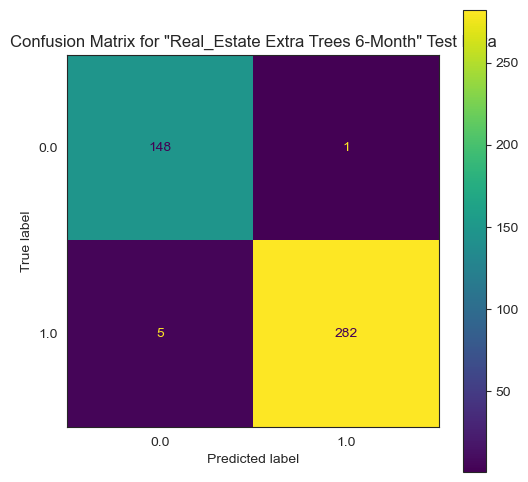

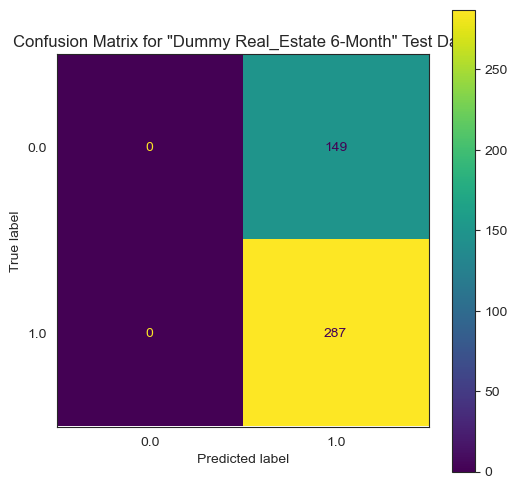

In [172]:
# Shows the best model's predictions and the dummy for that particular time horizon
Real_Estate[15].confusion_matrix(), Real_Estate[12].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [173]:
# Feature Importances for each time-horizon's best model
print_feature_importances(36, 40, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
one_up_bollinger_band    0.046569
upper_bollinger_band     0.044364
20_day_SMA               0.044055
Interest_Rates           0.041116
High                     0.041100
Name: Real Estate 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.049873
Interest_Rates          0.048065
Low                     0.044699
Close                   0.043549
upper_bollinger_band    0.041856
Name: Real Estate 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.063588
Low                     0.058285
cycle_year_1            0.052583
Close                   0.052014
upper_bollinger_band    0.051684
Name: Real Estate 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Low                      0.076653
upper_bollinger_band     0.071036
Adj Close                0

<hr style="border: 4px solid black">

# Communication Service XLC

The XLC has only existed since 2018, so once again we suffer from a lack of data, and perhaps our analysis of these results should be tempered by that fact. Feature Importances: GDP_Filled 0.337210 and cycle_year_3 0.295460 were two of the largest of the whole data set. I would have to attribute that to the lack of data more than being a true signal. The `median return on predicted "buys" for 12-Months was quite high at 24%.` The `worst outcome on a predicted "buy" was a loss of 2%`, which was surprisingly low. However, our X_train data only goes through October of 2022, which was very near to a market top. 

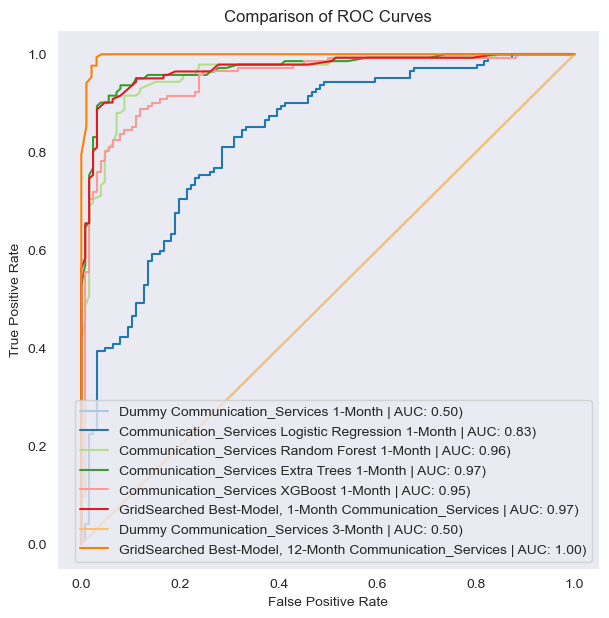

In [174]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Comms[0], Comms[1], Comms[2],Comms[3],Comms[4],Comms[5], \
                Comms[6], Comms[24]])

# 24 was the best model of this sector

### Best Models for the Sector

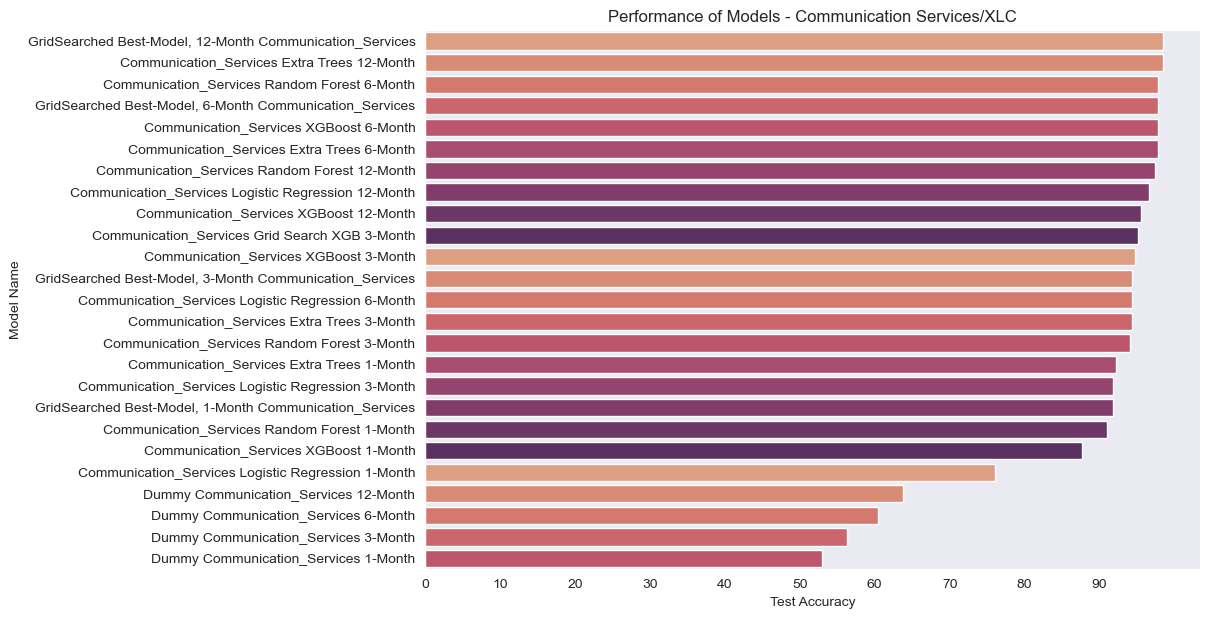

In [175]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Comms_df, "Communication Services/XLC", num_include=30)

In [176]:
# These were the models with the highest accuracy score for this ETF

Comms_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
24,"GridSearched Best-Model, 12-Month Communicatio...",0.985016,0.987254,0.990826,0.989015,0.092408,0.985075,0.982659,0.994152,0.988372,0.054820,0.997377
22,Communication_Services Extra Trees 12-Month,0.982516,0.985485,0.988991,0.987197,0.092167,0.985075,0.982659,0.994152,0.988372,0.046553,0.998704
15,Communication_Services Random Forest 6-Month,0.990000,0.993814,0.989754,0.991774,0.123804,0.977612,0.987500,0.975309,0.981366,0.086089,0.995341
18,"GridSearched Best-Model, 6-Month Communication...",0.990000,0.993814,0.989754,0.991774,0.123804,0.977612,0.987500,0.975309,0.981366,0.086089,0.995341
17,Communication_Services XGBoost 6-Month,0.977523,0.977734,0.985651,0.981663,0.086794,0.977612,0.993671,0.969136,0.981250,0.085382,0.996098


### How did our model perform when predicting "BUY"?
The best model was a 12-month `RandomForestClassifier`, and this was the first occassion an RFC took the top spot. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 23.2%. The worst outcome on a predicted "buy" was a loss of 2.8%.` This median gain is higher than other sectors.

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,173.000000,173.000000,173.000000,173.000000
mean,-0.001324,0.027990,0.101490,0.255506
std,0.065831,0.104429,0.123833,0.155653
min,-0.254661,-0.248306,-0.197751,-0.020621
25%,-0.036479,-0.048500,0.011796,0.149933
50%,0.005025,0.053532,0.107673,0.240554
75%,0.046094,0.105466,0.198366,0.365678
max,0.121977,0.278973,0.322851,0.711866


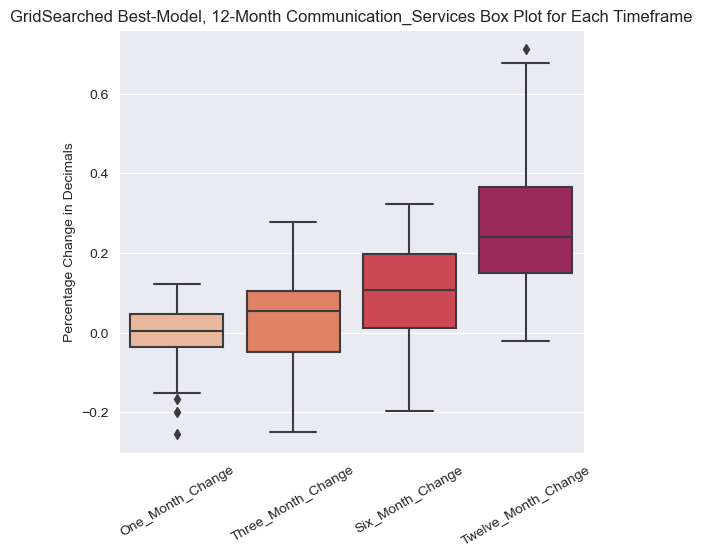

In [177]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Comms[24], "XLC", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

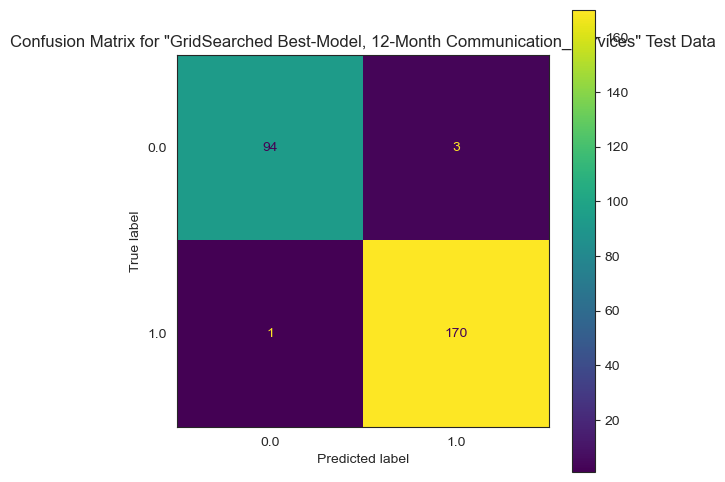

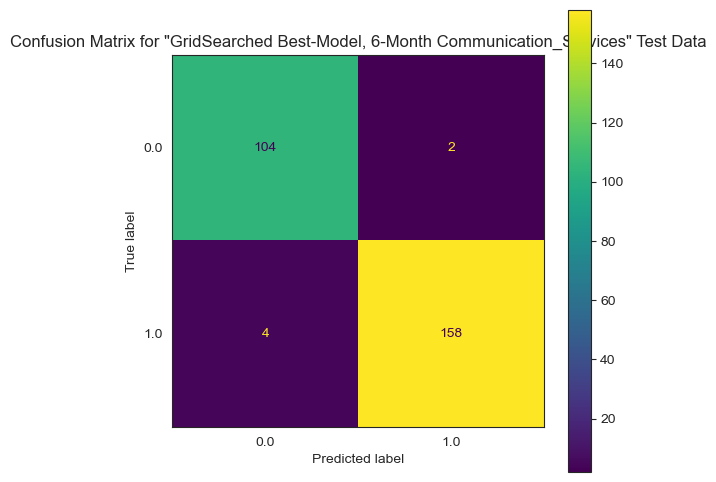

In [178]:
# Shows the best model's predictions and the dummy for that particular time horizon
Comms[24].confusion_matrix(), Comms[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [179]:
# Feature Importances for each time-horizon's best model
print_feature_importances(40, 44, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
cycle_year_2      0.095670
GDP_Filled        0.043530
MACD              0.039973
Interest_Rates    0.036925
Month_7           0.035107
Name: Communication Services 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled               0.337210
cycle_year_3             0.295460
lowest_bollinger_band    0.082599
Month_7                  0.067440
ATR                      0.065348
Name: Communication Services 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.113984
upper_bollinger_band    0.080058
20_day_SMA              0.064365
lower_bollinger_band    0.058721
Interest_Rates          0.058513
Name: Communication Services 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
one_up_bollinger_band    0.085872
upper_bollinger_band     0.083756
cycle_year_1           

<hr style="border: 6px solid red">

# Conclusions

The major trends in the analysis are that on longer time horizons, macro-economic factors have a greater influence on predictions, whereas technical indicators have a greater impact on short-term predictions. In the short-term, the adage "the trend is your friend" seems to pay off regularly. The top 5 models for each time horizon are accurate with ranges of: 
- 1-Month | 92-91.8%
- 3-Month | 96-95.6%
- 6-Month | 98.6 - 97.7%
- 12-Month | 98.7 - 98.5%

Predictions become more accurate in general as time horizons get larger. The best models and their profiles are described below.

### Best models for each time horizon (repeated at the top of the notebook)

In [180]:
# One Month
show_time_horizon(models_df, "One")[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
245,Communication_Services Extra Trees 1-Month,0.905093,0.923258,0.920461,0.921070,0.224529,0.921642,0.906040,0.950704,0.927835,0.235663,0.970909
199,"GridSearched Best-Model, 1-Month Consumer",0.901841,0.914124,0.930799,0.922370,0.287610,0.919865,0.919235,0.952643,0.935641,0.225776,0.972471
197,Consumer Extra Trees 1-Month,0.901167,0.911974,0.932233,0.921984,0.275765,0.918519,0.919957,0.949339,0.934417,0.229149,0.971568
101,Technology Extra Trees 1-Month,0.903416,0.914665,0.928156,0.921318,0.268386,0.918519,0.923830,0.943333,0.933480,0.223019,0.972975
247,"GridSearched Best-Model, 1-Month Communication...",0.917585,0.932046,0.931009,0.931198,0.225517,0.917910,0.905405,0.943662,0.924138,0.239445,0.969931


In [181]:
# Three Month
show_time_horizon(models_df, "Three")[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
205,"GridSearched Best-Model, 3-Month Consumer",0.941150,0.956009,0.954043,0.955022,0.173759,0.959596,0.963265,0.975207,0.969199,0.120060,0.992797
203,Consumer Extra Trees 3-Month,0.941150,0.956009,0.954043,0.955022,0.173759,0.959596,0.963265,0.975207,0.969199,0.120060,0.992797
109,"GridSearched Best-Model, 3-Month Technology",0.952829,0.955530,0.974737,0.964980,0.162295,0.958249,0.959486,0.978831,0.969062,0.155356,0.987532
106,Technology Random Forest 3-Month,0.952829,0.955530,0.974737,0.964980,0.162295,0.958249,0.959486,0.978831,0.969062,0.155356,0.987532
35,Energy Extra Trees 3-Month,0.939798,0.942024,0.962970,0.952365,0.213188,0.956229,0.950317,0.980371,0.965110,0.169099,0.987909


In [182]:
# Six Month
show_time_horizon(models_df, "Six")[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
233,Real_Estate Extra Trees 6-Month,0.969419,0.977478,0.974914,0.976106,0.095903,0.986239,0.996466,0.982578,0.989474,0.143288,0.995300
232,Real_Estate Random Forest 6-Month,0.964061,0.971785,0.972512,0.971971,0.108880,0.981651,0.992933,0.979094,0.985965,0.089284,0.994306
235,"GridSearched Best-Model, 6-Month Real_Estate",0.971712,0.977536,0.978500,0.977951,0.118885,0.979358,0.989437,0.979094,0.984238,0.070450,0.995884
260,"GridSearched Best-Model, 6-Month Communication...",0.990000,0.993814,0.989754,0.991774,0.123804,0.977612,0.987500,0.975309,0.981366,0.086089,0.995341
259,Communication_Services XGBoost 6-Month,0.977523,0.977734,0.985651,0.981663,0.086794,0.977612,0.993671,0.969136,0.981250,0.085382,0.996098


In [183]:
# Twelve Month
show_time_horizon(models_df, "Twelve")[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
121,"GridSearched Best-Model, 12-Month Technology",0.980231,0.981350,0.992506,0.986880,0.084918,0.987205,0.990222,0.992870,0.991544,0.052344,0.998891
118,Technology Random Forest 12-Month,0.978434,0.979596,0.991907,0.985694,0.077740,0.986532,0.990214,0.991979,0.991095,0.051671,0.998922
266,"GridSearched Best-Model, 12-Month Communicatio...",0.985016,0.987254,0.990826,0.989015,0.092408,0.985075,0.982659,0.994152,0.988372,0.054820,0.997377
264,Communication_Services Extra Trees 12-Month,0.982516,0.985485,0.988991,0.987197,0.092167,0.985075,0.982659,0.994152,0.988372,0.046553,0.998704
119,Technology Extra Trees 12-Month,0.980008,0.984525,0.988911,0.986693,0.072815,0.984512,0.988444,0.991087,0.989764,0.042637,0.999099


# 1-Month Most Accurate Model Profile

In [184]:
describe_predictions(Comms[5], "XLC", box=False)[["One_Month_Change"]]

Set 'box' to 'True' if you want to see box plots


,One_Month_Change
count,148.000000
mean,0.036533
std,0.033415
min,-0.077595
25%,0.014413
50%,0.032694
75%,0.053391
max,0.121977


# 3-Month Most Accurate Model Profile

In [185]:
describe_predictions(Consumer_Disc[11], "XLY")[["Three_Month_Change"]]

Set 'box' to 'True' if you want to see box plots


,Three_Month_Change
count,980.000000
mean,0.077219
std,0.063792
min,-0.069209
25%,0.029738
50%,0.069000
75%,0.105636
max,0.481793


# 6-Month Most Accurate Model Profile

In [186]:
describe_predictions(Real_Estate[15], "XLRE")[["Six_Month_Change"]]

Set 'box' to 'True' if you want to see box plots


,Six_Month_Change
count,283.000000
mean,0.110647
std,0.072271
min,-0.012052
25%,0.058976
50%,0.090572
75%,0.145317
max,0.347834


# 12-Month Most Accurate Model Profile

In [187]:
describe_predictions(Technology[23], "XLK")[["Twelve_Month_Change"]]

Set 'box' to 'True' if you want to see box plots


,Twelve_Month_Change
count,1125.000000
mean,0.214783
std,0.147210
min,-0.020982
25%,0.101288
50%,0.191351
75%,0.295962
max,0.879086


### Recommendation
Based only on these models, the 6-month Real Estate or 12-month Tech predictions have very appealing profiles, as the positive predictions produced very rare and very small losses. The worst return was -2%. The median performance of both would be around 20% annually, which is not too shabby. Overall, every model performed extremely well. The type of model most frequently employed was the ExtraTreesClassifier. I will have to continue to evaluate which model's predictions are the most profitable. 

I think that it also is worth mentioning the box plots demonstrate how every model's targeted timeframe has an extremely low rate of negative returns. Futhermore, the `outlier negative returns` in those situations are `extremely rare.` I would say that these models are very adept at minimizing risk.

### Next Steps:
The next steps would be to, of course, continue to update the data with more observations. It would also be beneficial to add more features, such as the price of various commodities, such as oil, gold, wheat etc. There is still the potential to add many additional technical indicators as well, and all of these factors could conceivably improve the performance of the models, even though they have already achieved remarkable accuracy. Thank you very much for considering the data in this notebook! 